In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

## <CENTER> 1. Reading Dataset </CENTER>

##### DATASET DESCRIPTION

> **training_sales.csv** contains hourly sales of a store in the US. 

        - Date: Date Time of the Sales
        - Value: Sales in cents

> **training_traffic.csv** contains hourly traffic of the same store in the US.

        - Date: Date Time of the Traffic
        - Value: Traffic data in person measured using store sensors



In [2]:
df_sales = pd.read_csv("training_Sales.csv")
df_traffic = pd.read_csv("training_Traffic.csv")

<center>Displaying the First 5 Data points if each dataset

In [3]:
df_sales.head()

,Date,Value
0,2013-11-07 13:00:00,830
1,2013-11-07 13:15:00,885
2,2013-11-07 13:30:00,938
3,2013-11-07 13:45:00,804
4,2013-11-07 14:00:00,793


In [4]:
df_traffic.head()

,Date,Value
0,2015-01-01 10:00:00,0
1,2015-01-01 10:15:00,1
2,2015-01-01 10:30:00,4
3,2015-01-01 10:45:00,3
4,2015-01-01 11:00:00,1


<center>Displaying datasets' info (Datatypes and Number of datapoints)

In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67058 entries, 0 to 67057
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    67058 non-null  object
 1   Value   67058 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [6]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58437 entries, 0 to 58436
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    58437 non-null  object
 1   Value   58437 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 913.2+ KB


## <CENTER> 2. Data Preparation and Exploration </CENTER>

#### This Section will focus on :
        - Preparing and cleaning the datasets
        - descriptive statistics 
        - Other useful analytics prior to modelling

<center> Renaming columns to resonable feature names and counting null/missing values in the Datasets

In [7]:
#Renaming the features 
df_sales.rename(columns={"Value":"Sales_cents"}, inplace=True)
df_traffic.rename(columns={"Value":"No_people"}, inplace=True)

<center> Changing the Datatypes to be able to perform anatics and other exploration

In [8]:
#Changing the data types of the dates to date data type from being objects
df_sales["Date"]= pd.to_datetime(df_sales["Date"],errors='coerce', infer_datetime_format=True)
df_traffic["Date"] = pd.to_datetime(df_traffic["Date"],errors='coerce', infer_datetime_format=True)

<center>Converting intervals 15 mins interval to an hour</center>

_Conversion of the timestamps to intervals of an hour to make it easier for the analysis as the main goal of this exercise is to identify the sales and traffic of the store for the next hour._

In [9]:
df_sales_temp = df_sales.resample('H', on="Date").sum(min_count=1).reset_index()
df_traffic_temp = df_traffic.resample('H', on="Date").sum(min_count=1).reset_index()

<center> Checking for Duplicates in the datasets </center>

_The Datasets does not seem to have duplicates_

In [10]:
print("Sales before dropping duplicates", df_sales.shape)
df_sales.drop_duplicates()
print("Salses after dropping duplicates " , df_sales.shape ) 


Sales before dropping duplicates (67058, 2)
Salses after dropping duplicates  (67058, 2)


In [11]:
print("Sales before dropping duplicates", df_traffic.shape)
df_traffic.drop_duplicates()
print("Traffic after dropping duplicates " , df_traffic.shape ) 


Sales before dropping duplicates (58437, 2)
Traffic after dropping duplicates  (58437, 2)


<center> Counting missing values 

In [12]:
df_sales_temp.isnull().sum()

Date               0
Sales_cents    20571
dtype: int64

In [13]:
df_traffic_temp.isnull().sum()

Date             0
No_people    11566
dtype: int64

<center> Handling Missing Values</center>

    The dataset is of time series, considering on US business hours of the United States, and adding a day of the week column in the data will help to identify the times when the store was closed and when the store was not making sales, because removing all the Null values implies that the store does not experience hours where there are no sales, which is likely false.


US Business hours

    Shopping Malls
        - Monday-Saturday: 10 a.m.-9 p.m
        - Sunday: 11 a.m.-6 p.m

    Supermarkets
        - Daily: 8 a.m.-8 p.m
        - Some open 24 hours
 


Removing the hours when the store is closed may appear to be removing information, but domain knowledge also aids in data exploration which makes this procedure not to be bias. Furthermore, the missing values during operating hours can be treated as a case of Missing Completely at Random (MCAR) in missig data and this missing type of data imputing can be used to impute the missing information. Conversely, the ones where the store was not operating is considered as a case where the data is not missing at random, setting them to zero is illogical because it will be assumed that their store did not make any sales/did not have customers while it was closed. 



In [14]:
df_sales_temp["weekday"] = df_sales_temp.Date.dt.day_name()

#Will Check for Saturday, Sunday and Monday for both dataset
sales_saturdays_times = df_sales_temp[df_sales_temp["weekday"]=="Saturday"]
sales_sundays_times = df_sales_temp[df_sales_temp["weekday"]=="Sunday"]
sales_monday_times = df_sales_temp[df_sales_temp["weekday"]=="Monday"]

#Removing the times where the store was not operating
df_sales_temp= df_sales_temp[((df_sales_temp["Date"].dt.hour<=22)&(df_sales_temp["Date"].dt.hour>=8))] #Weekdays
df_sales_temp= df_sales_temp.drop(df_sales_temp[(df_sales_temp["Date"].dt.hour==8) & (df_sales_temp["weekday"]=="Saturday")].index)#Saturday
df_sales_temp= df_sales_temp.drop(df_sales_temp[(df_sales_temp["Date"].dt.hour==8) & (df_sales_temp["weekday"]=="Sunday")].index)#Sundays
df_sales_temp= df_sales_temp.drop(df_sales_temp[(df_sales_temp["Date"].dt.hour==9) & (df_sales_temp["weekday"]=="Sunday")].index)#Sundays
df_sales_temp= df_sales_temp.drop(df_sales_temp[(df_sales_temp["Date"].dt.hour>=20) & (df_sales_temp["weekday"]=="Sunday")].index)#Sundays

df_sales_temp.drop(columns=["weekday"], inplace=True) #Removing the added column

In [15]:
df_traffic_temp["weekday"] = df_traffic_temp.Date.dt.day_name()

#Will Check for Saturday, Sunday and Monday for both dataset
traffic_saturdays_times = df_traffic_temp[df_traffic_temp["weekday"]=="Saturday"]
traffic_sundays_times = df_traffic_temp[df_traffic_temp["weekday"]=="Sunday"]
traffic_monday_times = df_traffic_temp[df_traffic_temp["weekday"]=="Monday"]

#Removing the times where the store was not operating
df_traffic_temp= df_traffic_temp[((df_traffic_temp["Date"].dt.hour<=22)&(df_traffic_temp["Date"].dt.hour>=8))] #Weekdays
df_traffic_temp= df_traffic_temp.drop(df_traffic_temp[(df_traffic_temp["Date"].dt.hour==8) & (df_traffic_temp["weekday"]=="Saturday")].index)#Saturday
df_traffic_temp= df_traffic_temp.drop(df_traffic_temp[(df_traffic_temp["Date"].dt.hour==8) & (df_traffic_temp["weekday"]=="Sunday")].index)#Sundays
df_traffic_temp= df_traffic_temp.drop(df_traffic_temp[(df_traffic_temp["Date"].dt.hour==9) & (df_traffic_temp["weekday"]=="Sunday")].index)#Sundays
df_traffic_temp= df_traffic_temp.drop(df_traffic_temp[(df_traffic_temp["Date"].dt.hour>=20) & (df_traffic_temp["weekday"]=="Sunday")].index)#Sundays

df_traffic_temp.drop(columns=["weekday"], inplace=True) #Removing the added column

<center>Displaying the nulls representing where the store did not make sales and did not experience traffic.</center>

**Note**: The Nan represent where the store did not make sales which will be update to Zero in the preeceding step and the exra weekday columns represents the day of which the store was operating.

In [16]:
df_sales_temp[df_sales_temp.isnull().any(axis=1)]

,Date,Sales_cents
2,2013-11-07 15:00:00,NaN
4,2013-11-07 17:00:00,NaN
6,2013-11-07 19:00:00,NaN
8,2013-11-07 21:00:00,NaN
9,2013-11-07 22:00:00,NaN
...,...,...
39345,2018-05-04 22:00:00,NaN
39356,2018-05-05 09:00:00,NaN
39368,2018-05-05 21:00:00,NaN
39369,2018-05-05 22:00:00,NaN


In [17]:
df_traffic_temp[df_traffic_temp.isnull().any(axis=1)]

,Date,No_people
11,2015-01-01 21:00:00,NaN
12,2015-01-01 22:00:00,NaN
94,2015-01-05 08:00:00,NaN
118,2015-01-06 08:00:00,NaN
132,2015-01-06 22:00:00,NaN
...,...,...
29182,2018-05-01 08:00:00,NaN
29206,2018-05-02 08:00:00,NaN
29220,2018-05-02 22:00:00,NaN
29230,2018-05-03 08:00:00,NaN


_Null Values are replaced with Zero (0) to indicate instances when the store did not generate sales or did not count the number of persons in-store._

In [18]:
df_sales_temp.fillna(0,inplace=True)
df_traffic_temp.fillna(0,inplace=True)

In [19]:
df_sales_temp

,Date,Sales_cents
0,2013-11-07 13:00:00,3457.0
1,2013-11-07 14:00:00,2250.0
2,2013-11-07 15:00:00,0.0
3,2013-11-07 16:00:00,729.0
4,2013-11-07 17:00:00,0.0
...,...,...
39386,2018-05-06 15:00:00,3645.0
39387,2018-05-06 16:00:00,3372.0
39388,2018-05-06 17:00:00,3077.0
39389,2018-05-06 18:00:00,3190.0


In [20]:
df_traffic_temp

,Date,No_people
0,2015-01-01 10:00:00,8.0
1,2015-01-01 11:00:00,14.0
2,2015-01-01 12:00:00,28.0
3,2015-01-01 13:00:00,33.0
4,2015-01-01 14:00:00,47.0
...,...,...
29309,2018-05-06 15:00:00,41.0
29310,2018-05-06 16:00:00,33.0
29311,2018-05-06 17:00:00,27.0
29312,2018-05-06 18:00:00,14.0


<center>Plotting the Two datasets with converted intervals and operation hours only

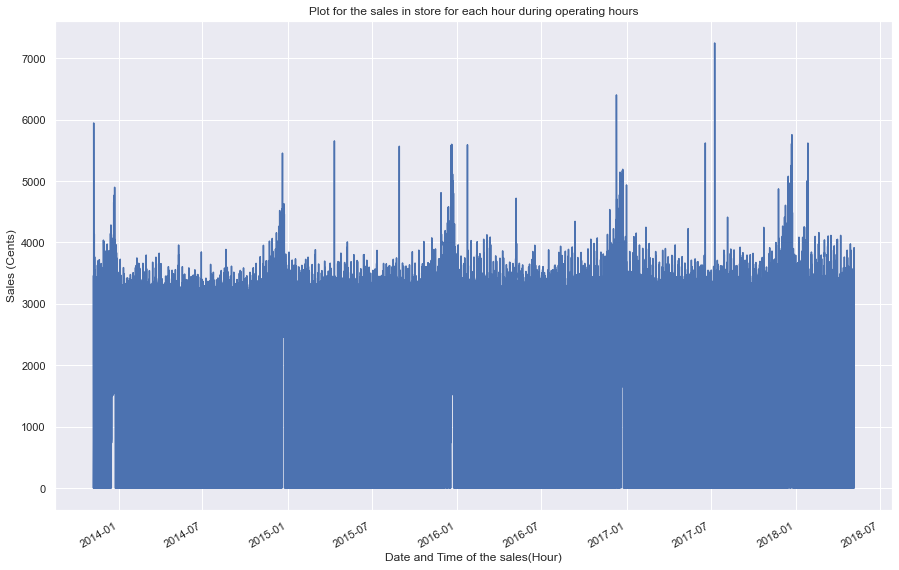

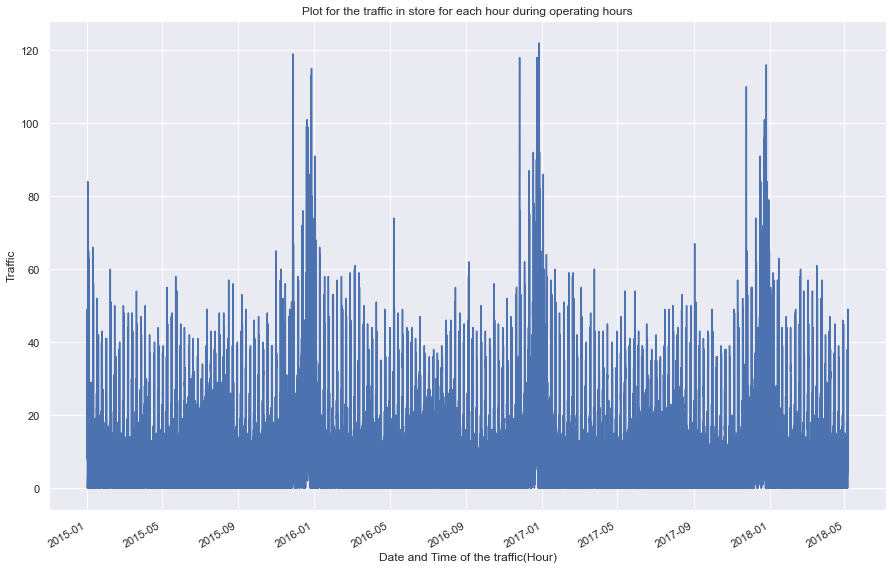

In [21]:
df_sales_temp.plot(x="Date", y="Sales_cents",figsize=(15,10), legend=False)
plt.title("Plot for the sales in store for each hour during operating hours")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")
plt.show()


df_traffic_temp.plot(x="Date", y="No_people",figsize=(15,10), legend=False)
plt.title("Plot for the traffic in store for each hour during operating hours")
plt.xlabel("Date and Time of the traffic(Hour)")
plt.ylabel("Traffic")
plt.show()


Noticing from the plots, there's an annual time where the sales and traffic are zero which is towards year end. Below I will test if the store operates in chrismas or not because other retail stores do operate 

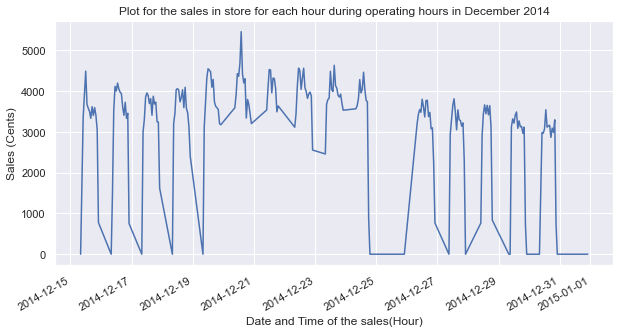

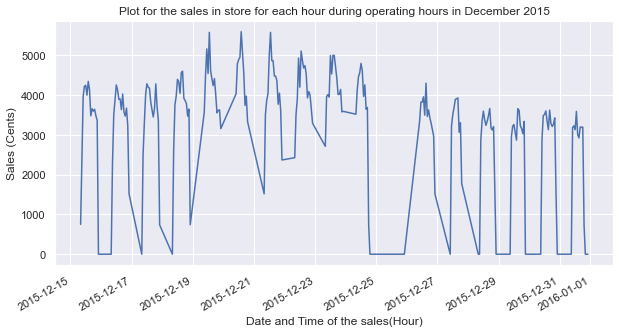

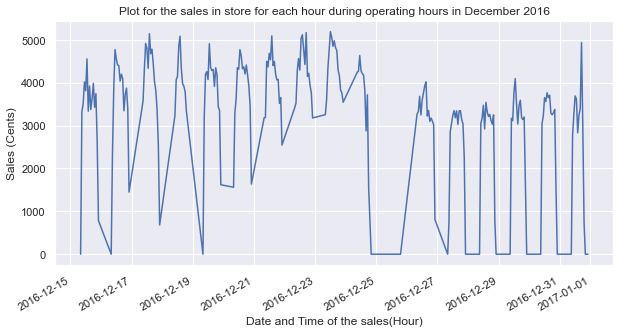

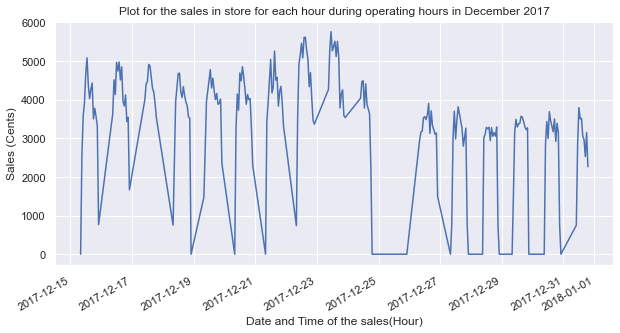

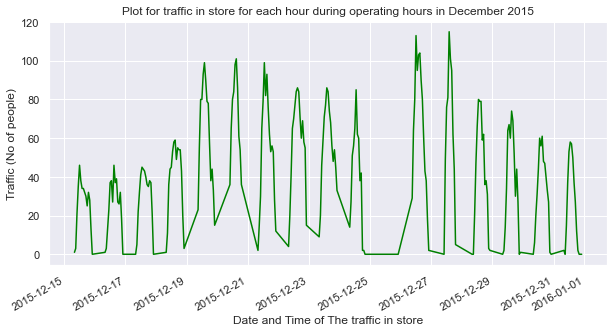

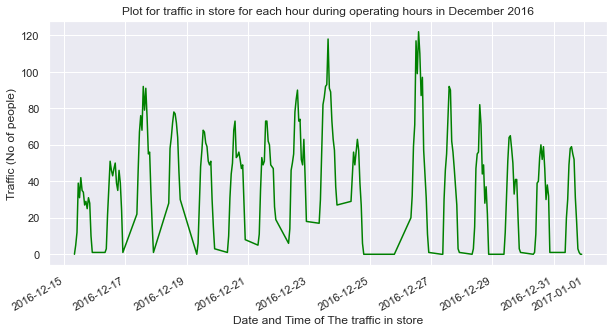

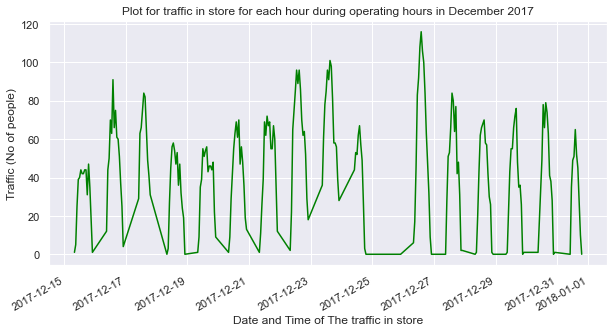

In [22]:
for i in [2014,2015,2016,2017]:
    plot_df = df_sales_temp[((df_sales_temp["Date"].dt.month==12)&(df_sales_temp["Date"].dt.day>=15)&(df_sales_temp["Date"].dt.year==i))]
    plot_df.plot(x="Date", y="Sales_cents",figsize=(10,5), legend=False)
    plt.title(f"Plot for the sales in store for each hour during operating hours in December {i}")
    plt.xlabel("Date and Time of the sales(Hour)")
    plt.ylabel("Sales (Cents)")
    plt.show()

for i in [2015,2016,2017]:
    plot_df = df_traffic_temp[((df_traffic_temp["Date"].dt.month==12)&(df_traffic_temp["Date"].dt.day>=15)&(df_traffic_temp["Date"].dt.year==i))]
    plot_df.plot(x="Date", y="No_people",figsize=(10,5), legend=False, color="green")
    plt.title(f"Plot for traffic in store for each hour during operating hours in December {i}")
    plt.xlabel("Date and Time of The traffic in store")
    plt.ylabel("Traffic (No of people)")
    plt.show()

As seen from the plots the store does not operate on christmas as there are gaps

In [23]:
#More testing whether the store operates on chrismas or not
christmas_operating_test_sales = df_sales_temp[((df_sales_temp["Date"].dt.month==12)&(df_sales_temp["Date"].dt.day==25))]
christmas_operating_test_traffic = df_traffic_temp[((df_traffic_temp["Date"].dt.month==12)&(df_traffic_temp["Date"].dt.day==25))]


summation_sales = christmas_operating_test_sales["Sales_cents"].sum()
summation_traffic = christmas_operating_test_traffic["No_people"].sum()

print(f"Total sales made/traffic experienced on 25th's of December since 2014 till 2017 are {summation_sales} and {summation_traffic}")

Total sales made/traffic experienced on 25th's of December since 2014 till 2017 are 0.0 and 0.0


The results show that the store does not operate on christmas, Thus christmas will be removed from the datasets.

In [24]:
df_sales_temp = df_sales_temp[~((df_sales_temp["Date"].dt.month==12)&(df_sales_temp["Date"].dt.day==25))]
df_traffic_temp = df_traffic_temp[~((df_traffic_temp["Date"].dt.month==12)&(df_traffic_temp["Date"].dt.day==25))]

The Plot after removing 25th December for each year shows that there's still a gap in the plots though I have removed the data points on Christmas.

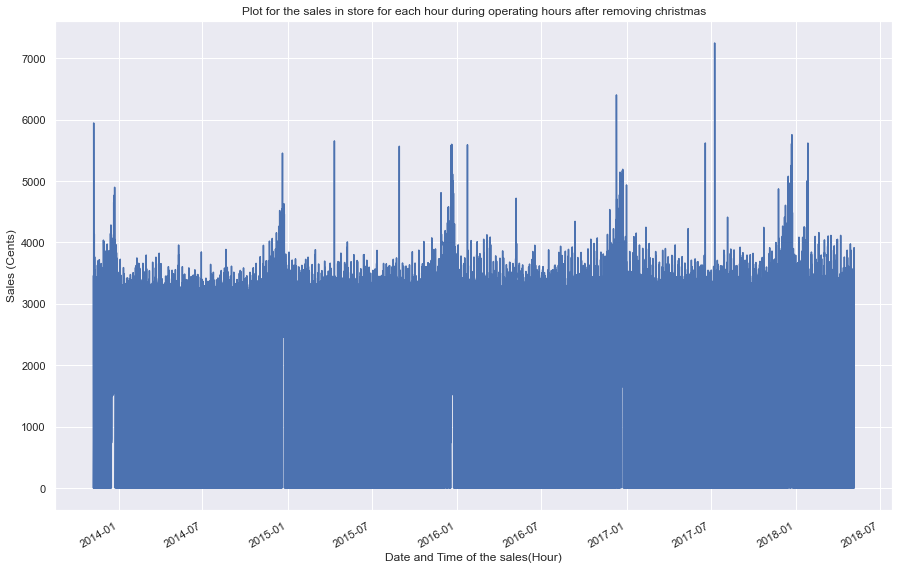

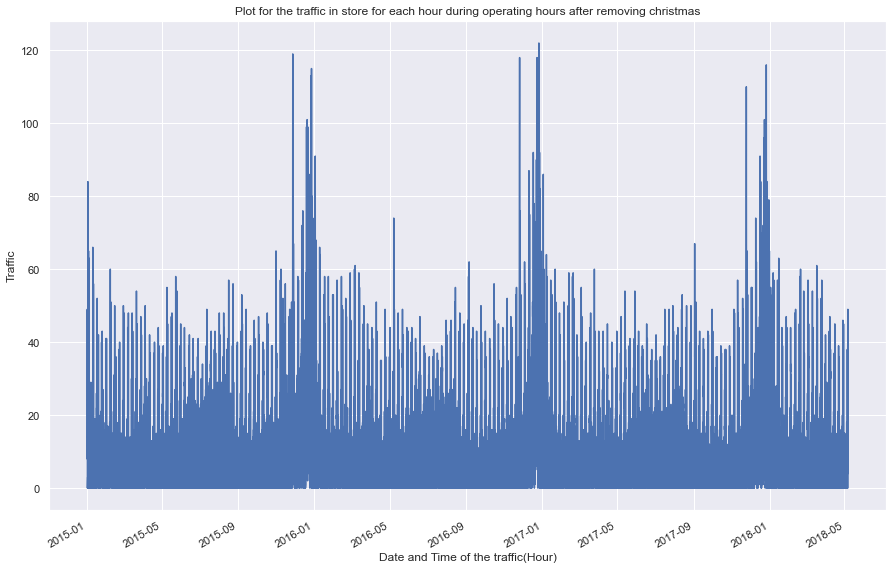

In [25]:
df_sales_temp.plot(x="Date", y="Sales_cents",figsize=(15,10), legend=False)
plt.title("Plot for the sales in store for each hour during operating hours after removing christmas")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")
plt.show()

df_traffic_temp.plot(x="Date", y="No_people",figsize=(15,10), legend=False)
plt.title("Plot for the traffic in store for each hour during operating hours after removing christmas")
plt.xlabel("Date and Time of the traffic(Hour)")
plt.ylabel("Traffic")
plt.show()


<center> US Holidays and Other Events (Black Friday, Cyber Monday etc) </center>

    New Year’s Day: Jan. 1
    Martin Luther King Jr. Day: Third Monday in January
    Presidents’ Day: Third Monday in February
    Memorial Day: Last Monday in May
    Independence Day: July 4
    Labor Day: First Monday in September
    Columbus Day: Second Monday in October
    Veterans Day: Nov. 11
    Thanksgiving: Fourth Thursday in November
    Christmas Day: Dec. 25

    Black Friday: Friday after Thanksgiving
    Cyber Monday: Monday after Black Friday/Thanksgiving
    Small Business Saturday: Saturday after black friday
    Sofa Sunday : Sunday After Black Friday
    


In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar # t_series of holidays of the united state of America


holidays_sales = list(USFederalHolidayCalendar().holidays(start=df_sales_temp.Date.min().date(), end=df_sales_temp.Date.max().date()).date)
holidays_traffic = list(USFederalHolidayCalendar().holidays(start=df_traffic_temp.Date.min().date(), end=df_traffic_temp.Date.max().date()).date)

#Black Friday
black_friday_2013 = datetime.strptime("2013-11-29", "%Y-%m-%d").date()
black_friday_2014 = datetime.strptime("2014-11-28", "%Y-%m-%d").date()
black_friday_2015 = datetime.strptime("2015-11-27", "%Y-%m-%d").date()
black_friday_2016 = datetime.strptime("2016-11-25", "%Y-%m-%d").date()
black_friday_2017 = datetime.strptime("2017-11-24", "%Y-%m-%d").date()
black_fridays =[black_friday_2013, black_friday_2014, black_friday_2015, black_friday_2016, black_friday_2017]


business_saturday_2013 = datetime.strptime("2013-11-30", "%Y-%m-%d").date()
business_saturday_2014 = datetime.strptime("2014-11-29", "%Y-%m-%d").date()
business_saturday_2015 = datetime.strptime("2015-11-28", "%Y-%m-%d").date()
business_saturday_2016 = datetime.strptime("2016-11-26", "%Y-%m-%d").date()
business_saturday_2017 = datetime.strptime("2017-11-25", "%Y-%m-%d").date()
business_saturdays =[business_saturday_2013, business_saturday_2014, business_saturday_2015, business_saturday_2016, business_saturday_2017]


sofa_sunday_2013 = datetime.strptime("2013-12-01", "%Y-%m-%d").date()
sofa_sunday_2014 = datetime.strptime("2014-11-30", "%Y-%m-%d").date()
sofa_sunday_2015 = datetime.strptime("2015-11-29", "%Y-%m-%d").date()
sofa_sunday_2016 = datetime.strptime("2016-11-27", "%Y-%m-%d").date()
sofa_sunday_2017 = datetime.strptime("2017-11-26", "%Y-%m-%d").date()
sofa_sundays =[sofa_sunday_2013, sofa_sunday_2014, sofa_sunday_2015, sofa_sunday_2016, sofa_sunday_2017]


cyber_monday_2013 = datetime.strptime("2013-12-02", "%Y-%m-%d").date()
cyber_monday_2014 = datetime.strptime("2014-11-01", "%Y-%m-%d").date()
cyber_monday_2015 = datetime.strptime("2015-11-30", "%Y-%m-%d").date()
cyber_monday_2016 = datetime.strptime("2016-11-28", "%Y-%m-%d").date()
cyber_monday_2017 = datetime.strptime("2016-11-27", "%Y-%m-%d").date()
cyber_mondays = [cyber_monday_2013, cyber_monday_2014, cyber_monday_2015, cyber_monday_2016, cyber_monday_2017]


for date in black_fridays:
    if date not in holidays_sales:
        holidays_sales.append(date)
    if date not in holidays_traffic:
        holidays_traffic.append(date)
for date in business_saturdays:
    if date not in holidays_sales:
        holidays_sales.append(date)
    if date not in holidays_traffic:
        holidays_traffic.append(date)
for date in sofa_sundays:
    if date not in holidays_sales:
        holidays_sales.append(date)
    if date not in holidays_traffic:
        holidays_traffic.append(date)
for date in cyber_mondays:
    if date not in holidays_sales:
        holidays_sales.append(date)
    if date not in holidays_traffic:
        holidays_traffic.append(date)


df_sales_temp["date_only"]= df_sales_temp["Date"].dt.date
df_sales_temp['Events_holidays'] = df_sales_temp.date_only.isin(holidays_sales).astype(int)

df_traffic_temp["date_only"]= df_traffic_temp["Date"].dt.date
df_traffic_temp['Events_holidays'] = df_traffic_temp.date_only.isin(holidays_traffic).astype(int)

df_sales_temp.drop(columns=["date_only"], inplace=True)
df_traffic_temp.drop(columns=["date_only"], inplace=True)

    Displaying the Holidays and Events Dataframes overview

In [27]:
#Overview of the new traffic dataframe
df_traffic_temp

,Date,No_people,Events_holidays
0,2015-01-01 10:00:00,8.0,1
1,2015-01-01 11:00:00,14.0,1
2,2015-01-01 12:00:00,28.0,1
3,2015-01-01 13:00:00,33.0,1
4,2015-01-01 14:00:00,47.0,1
...,...,...,...
29309,2018-05-06 15:00:00,41.0,0
29310,2018-05-06 16:00:00,33.0,0
29311,2018-05-06 17:00:00,27.0,0
29312,2018-05-06 18:00:00,14.0,0


In [28]:
#Overview of the new sales dataframe
df_sales_temp

,Date,Sales_cents,Events_holidays
0,2013-11-07 13:00:00,3457.0,0
1,2013-11-07 14:00:00,2250.0,0
2,2013-11-07 15:00:00,0.0,0
3,2013-11-07 16:00:00,729.0,0
4,2013-11-07 17:00:00,0.0,0
...,...,...,...
39386,2018-05-06 15:00:00,3645.0,0
39387,2018-05-06 16:00:00,3372.0,0
39388,2018-05-06 17:00:00,3077.0,0
39389,2018-05-06 18:00:00,3190.0,0


In [29]:
#There are 944 datapoints representing hourly sales made on holidays or events 
sales_df_holiday = df_sales_temp[df_sales_temp["Events_holidays"]==1]
sales_df_holiday

,Date,Sales_cents,Events_holidays
91,2013-11-11 08:00:00,0.0,1
92,2013-11-11 09:00:00,0.0,1
93,2013-11-11 10:00:00,2374.0,1
94,2013-11-11 11:00:00,3357.0,1
95,2013-11-11 12:00:00,3554.0,1
...,...,...,...
37565,2018-02-19 18:00:00,2335.0,1
37566,2018-02-19 19:00:00,1577.0,1
37567,2018-02-19 20:00:00,2294.0,1
37568,2018-02-19 21:00:00,733.0,1


In [30]:
#There are 640 data points representing hourly traffic experienced on holidays or events
traffic_df_holiday = df_traffic_temp[df_traffic_temp["Events_holidays"]==1]
traffic_df_holiday

,Date,No_people,Events_holidays
0,2015-01-01 10:00:00,8.0,1
1,2015-01-01 11:00:00,14.0,1
2,2015-01-01 12:00:00,28.0,1
3,2015-01-01 13:00:00,33.0,1
4,2015-01-01 14:00:00,47.0,1
...,...,...,...
27488,2018-02-19 18:00:00,11.0,1
27489,2018-02-19 19:00:00,10.0,1
27490,2018-02-19 20:00:00,4.0,1
27491,2018-02-19 21:00:00,2.0,1


<center> Plotting the sales and traffic on normal operting hours and on holidays</center>

The plots show that on holidays/events there is a pattern (seasonality) in sales annually, which could be caused by events such as Black friday as the seasonality occurs annually towards the end of the year. Similarly with the traffic in store, there's a seasonality as well annually towards year end which is logical as more sales could implies that there are more people in store. 

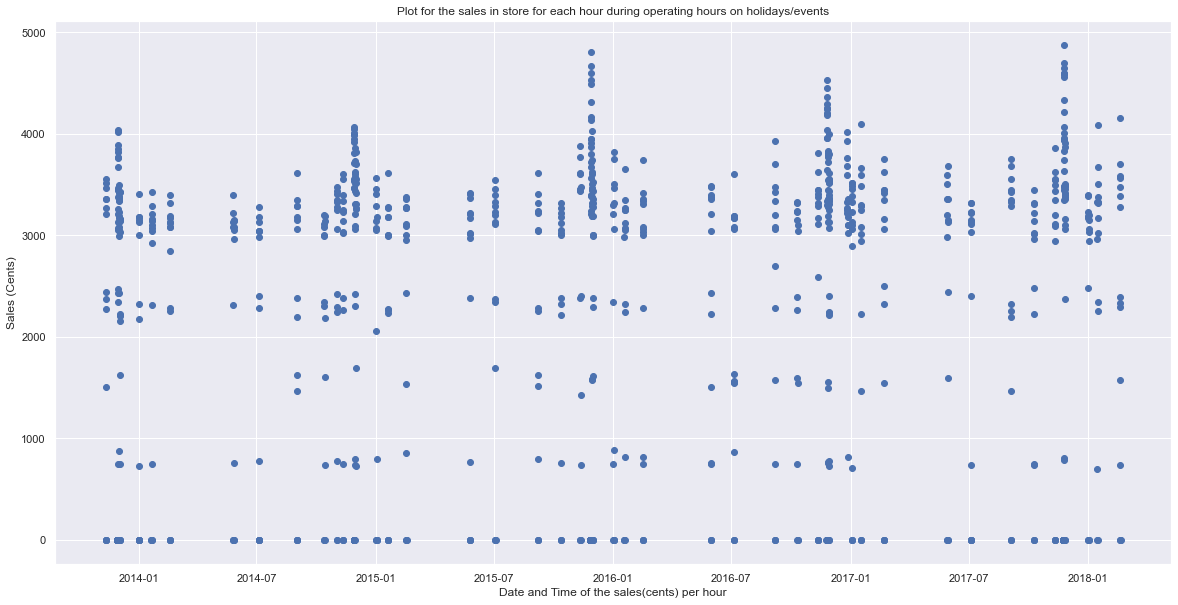

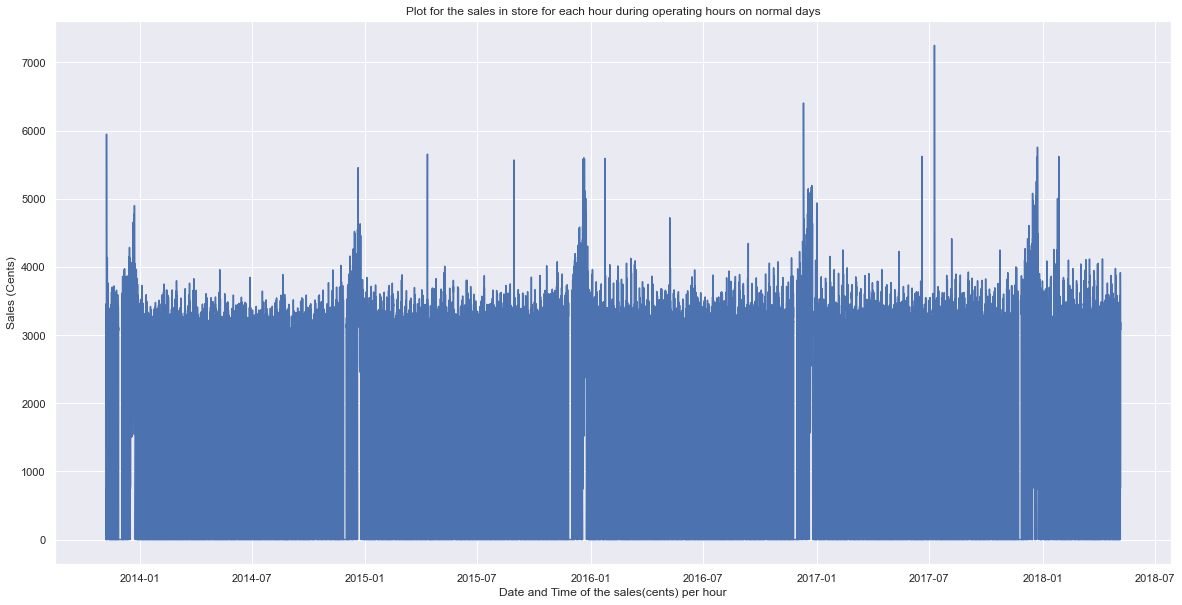

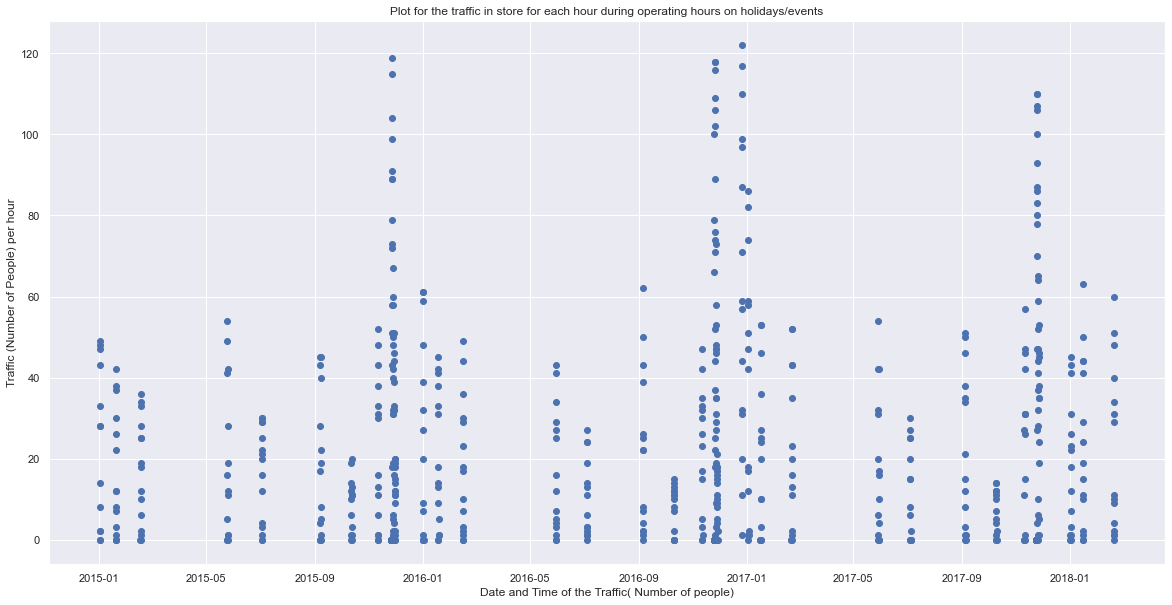

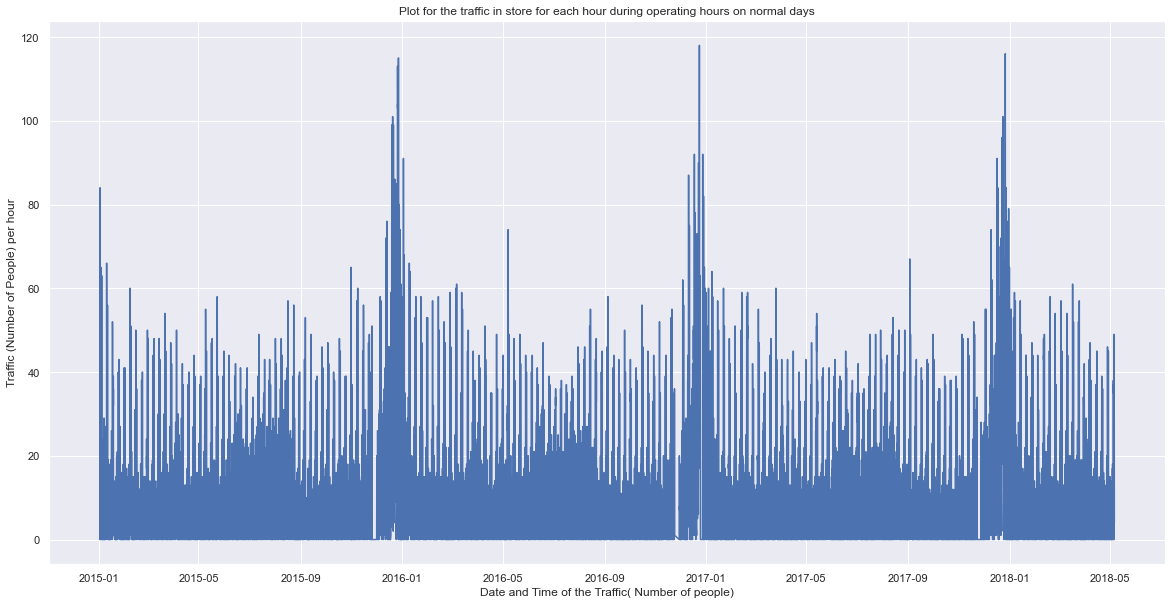

In [31]:
#Plots
df_sales_normal = df_sales_temp[df_sales_temp.Events_holidays==0]
df_sales_normal.set_index("Date", inplace=True)
sales_df_holiday.set_index("Date",inplace=True)

df_traffic_normal = df_traffic_temp[df_traffic_temp.Events_holidays==0]
df_traffic_normal.set_index("Date", inplace=True)
traffic_df_holiday.set_index("Date",inplace=True)

fig, normal = plt.subplots(ncols=1, nrows=1, figsize=(20,10))

normal.scatter(x=sales_df_holiday.index, y=sales_df_holiday[["Sales_cents"]])
normal.set_title("Plot for the sales in store for each hour during operating hours on holidays/events")
normal.set_xlabel("Date and Time of the sales(cents) per hour")
normal.set_ylabel("Sales (Cents)")
plt.show()


fig, normal = plt.subplots(ncols=1, nrows=1, figsize=(20,10))
normal.plot(df_sales_normal.Sales_cents)
normal.set_title("Plot for the sales in store for each hour during operating hours on normal days")
normal.set_xlabel("Date and Time of the sales(cents) per hour")
normal.set_ylabel("Sales (Cents)")
plt.show()


fig, normal = plt.subplots(ncols=1, nrows=1, figsize=(20,10))

normal.scatter(x=traffic_df_holiday.index, y=traffic_df_holiday[["No_people"]])
normal.set_title("Plot for the traffic in store for each hour during operating hours on holidays/events")
normal.set_xlabel("Date and Time of the Traffic( Number of people)")
normal.set_ylabel("Traffic (Number of People) per hour")
plt.show()

fig, normal = plt.subplots(ncols=1, nrows=1, figsize=(20,10))
normal.plot(df_traffic_normal.No_people)
normal.set_title("Plot for the traffic in store for each hour during operating hours on normal days")
normal.set_xlabel("Date and Time of the Traffic( Number of people)")
normal.set_ylabel("Traffic (Number of People) per hour")
plt.show()


<center> US Seasons (meteorological seasons) </center>

    - Spring months: March, April, May
    - Summer months: June, July, August
    - Fall months: September, October, November
    - Winter months: December, January, February

https://www.calendarr.com/united-states/seasons-of-the-year-in-the-united-states/

In [32]:
season_dict = {'January': 'Winter',
               'February': 'Winter',
               'March': 'Spring', 
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'July': 'Summer',
               'August': 'Summer',
               'September': 'Fall',
               'October': 'Fall',
               'November': 'Fall',
               'December': 'Winter'}

df_sales_temp["month"]=df_sales_temp.Date.dt.month_name()
df_traffic_temp["month"]=df_traffic_temp.Date.dt.month_name()

df_sales_temp["Season"]=df_sales_temp["month"].apply(lambda x : season_dict[x])
df_traffic_temp["Season"]=df_traffic_temp["month"].apply(lambda x : season_dict[x])


df_sales_temp.drop(columns=["month"],inplace=True)
df_traffic_temp.drop(columns=["month"],inplace=True)


Using labelling intead of One-hot-encoding adds more features with are dummies and does not weigh it differently. Thus, I used labelling to label the categories in seasons.

    Sales series:
     - Winter =2
     - Other seasons=1

    Traffic Series
     - Winter = 3
     - Sumemr = 2
     - Spring and Fall =1


In [33]:
#Labeling the mateorological according to their effect on sales
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
# df_sales_temp['Season'] = labelencoder.fit_transform(df_sales_temp['Season'])

#Winter seasonality presents
#Other seasons the sales are average
df_sales_temp.replace("Winter", 2, inplace=True)
df_sales_temp.replace(["Spring","Summer","Fall"], 1, inplace=True)


In [34]:
#Labeling the mateorological according to their effect on Traffic

#Winter seasonality presents
#Weak seasonality summer
#Fall and Spring do not have much seasonality
df_traffic_temp.replace("Winter", 3, inplace=True)
df_traffic_temp.replace("Summer", 2, inplace=True)
df_traffic_temp.replace(["Spring","Fall"], 1, inplace=True)

In [35]:
#Overview of the sales series after labelling
df_sales_temp

,Date,Sales_cents,Events_holidays,Season
0,2013-11-07 13:00:00,3457.0,0,1
1,2013-11-07 14:00:00,2250.0,0,1
2,2013-11-07 15:00:00,0.0,0,1
3,2013-11-07 16:00:00,729.0,0,1
4,2013-11-07 17:00:00,0.0,0,1
...,...,...,...,...
39386,2018-05-06 15:00:00,3645.0,0,1
39387,2018-05-06 16:00:00,3372.0,0,1
39388,2018-05-06 17:00:00,3077.0,0,1
39389,2018-05-06 18:00:00,3190.0,0,1


In [36]:
#Overview of the Traffic series after labelling
df_traffic_temp

,Date,No_people,Events_holidays,Season
0,2015-01-01 10:00:00,8.0,1,3
1,2015-01-01 11:00:00,14.0,1,3
2,2015-01-01 12:00:00,28.0,1,3
3,2015-01-01 13:00:00,33.0,1,3
4,2015-01-01 14:00:00,47.0,1,3
...,...,...,...,...
29309,2018-05-06 15:00:00,41.0,0,1
29310,2018-05-06 16:00:00,33.0,0,1
29311,2018-05-06 17:00:00,27.0,0,1
29312,2018-05-06 18:00:00,14.0,0,1


<center>Discriptive Statistics and Outliers</center>


_Displaying the descriptive statisrtics if the datasets before detecting the outliers to replace the ouliers with the average sales/traffic if I detect one because this is time series data removing data points will have an effect on my model's ability for forecasting_

In [37]:
df_sales_temp.describe().round(2)

,Sales_cents,Events_holidays,Season
count,23145.00,23145.00,23145.00
mean,2351.82,0.04,1.27
std,1340.32,0.19,0.45
min,0.00,0.00,1.00
25%,1495.00,0.00,1.00
50%,3062.00,0.00,1.00
75%,3263.00,0.00,2.00
max,7249.00,1.00,2.00


In [38]:
df_traffic_temp.describe().round(2)

,No_people,Events_holidays,Season
count,17238.00,17238.00,17238.00
mean,14.18,0.04,1.76
std,15.08,0.18,0.85
min,0.00,0.00,1.00
25%,3.00,0.00,1.00
50%,10.00,0.00,1.00
75%,19.00,0.00,3.00
max,122.00,1.00,3.00


_From the obtained results, the only visible outlier using domain knowledge is the one on 2017-07-09 at 19:00:00 as it is not a holiday because only time when sales are high is year-end and at the beginning of each year. In addition, considering the traffic on this day, it shows that the traffic was low at this day and time which makes the argument that this is an outlier caused by an error or more sales were made than usual at random. Lastly, the season that on this date was not summer where there are peaks in sales which makes it an outlier._

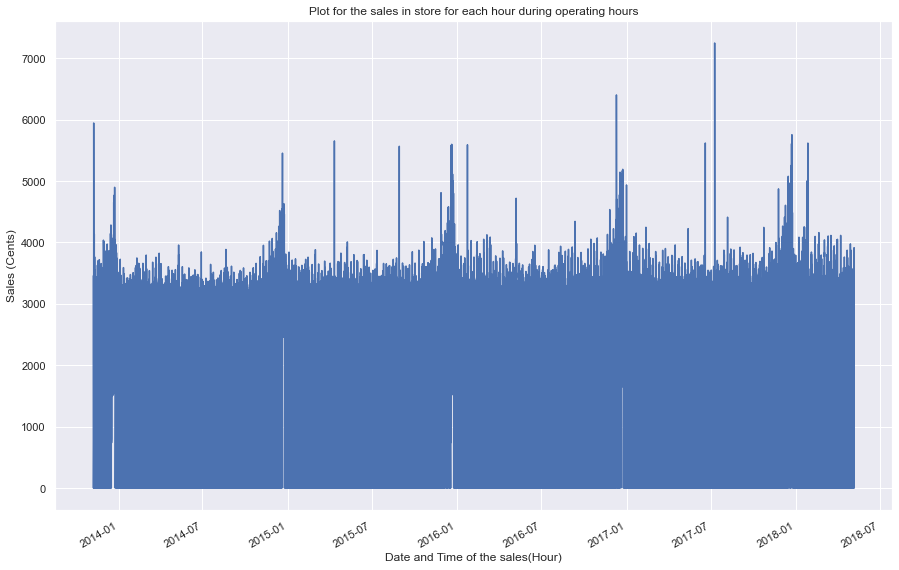

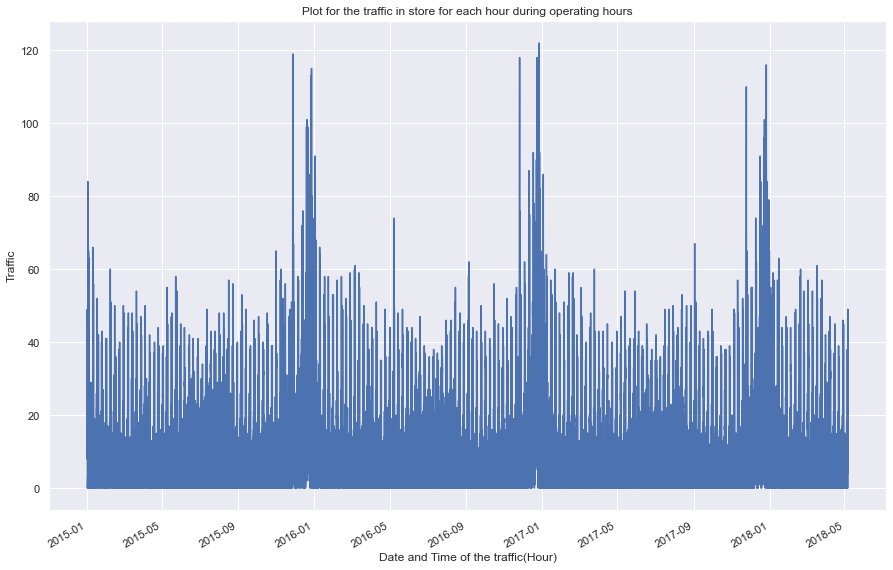

In [39]:
df_sales_temp.plot(x="Date", y="Sales_cents",figsize=(15,10), legend=False)
plt.title("Plot for the sales in store for each hour during operating hours")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")
plt.show()


df_traffic_temp.plot(x="Date", y="No_people",figsize=(15,10), legend=False)
plt.title("Plot for the traffic in store for each hour during operating hours")
plt.xlabel("Date and Time of the traffic(Hour)")
plt.ylabel("Traffic")
plt.show()


In [40]:
df_sales_temp.nlargest(4, columns=["Sales_cents"])

,Date,Sales_cents,Events_holidays,Season
32166,2017-07-09 19:00:00,7249.0,0,1
27081,2016-12-09 22:00:00,6403.0,0,2
21,2013-11-08 10:00:00,5946.0,0,1
36166,2017-12-23 11:00:00,5755.0,0,2


In [41]:
df_traffic_temp.nlargest(4, columns=["No_people"])

,Date,No_people,Events_holidays,Season
17404,2016-12-26 14:00:00,122.0,1,3
7922,2015-11-27 12:00:00,119.0,1,1
16658,2016-11-25 12:00:00,118.0,1,1
16661,2016-11-25 15:00:00,118.0,1,1


In [42]:
#Handling the outlier
outlier= max(df_sales_temp.nlargest(1, columns=["Sales_cents"])["Sales_cents"])
df_sales_temp.replace(outlier, df_sales_temp["Sales_cents"].mean(),inplace=True)

In [43]:
#Dataframe afte applyign remedy on the outliers
df_sales_temp.nlargest(4, columns=["Sales_cents"])

,Date,Sales_cents,Events_holidays,Season
27081,2016-12-09 22:00:00,6403.0,0,2
21,2013-11-08 10:00:00,5946.0,0,1
36166,2017-12-23 11:00:00,5755.0,0,2
12481,2015-04-11 14:00:00,5654.0,0,1


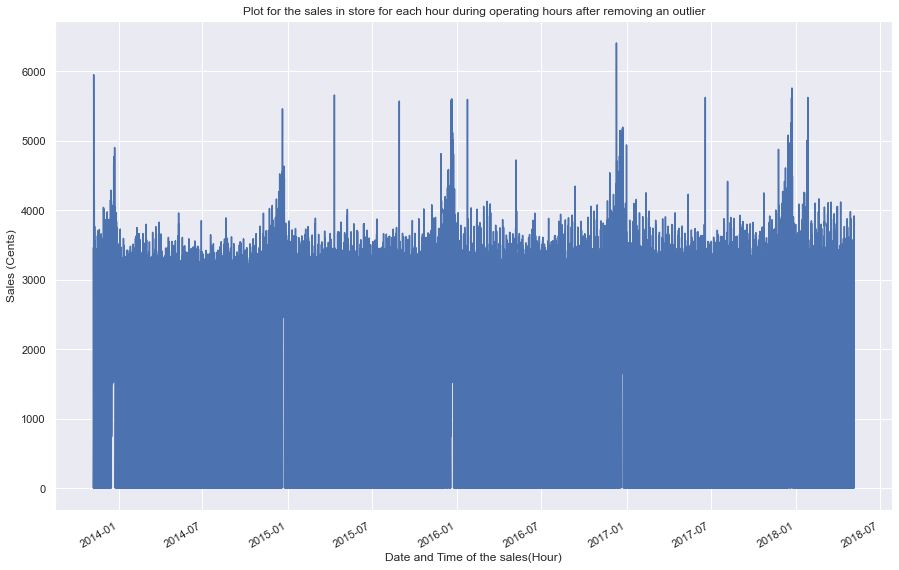

In [44]:
#Plot after removing the outlier
df_sales_temp.plot(x="Date", y="Sales_cents",figsize=(15,10), legend=False)
plt.title("Plot for the sales in store for each hour during operating hours after removing an outlier")
plt.xlabel("Date and Time of the sales(Hour)")
plt.ylabel("Sales (Cents)")
plt.show()

<center>Stationarity</center>


_The previous plot doesn't show much information on the patterns as it has multiple, the plot below will diplay the datasets in a rolling window for a week to be able to tell whether there is seasonality on the datasets or otherwise_

    The weekly window shows that there's a trend in sales and there's seasonality occuring at the begining of each year. On the other hand, the Traffic weekly plot indicates that there's also seasonality occuring at the begining of each year and the plot doesn't seem to have an obvious trend.

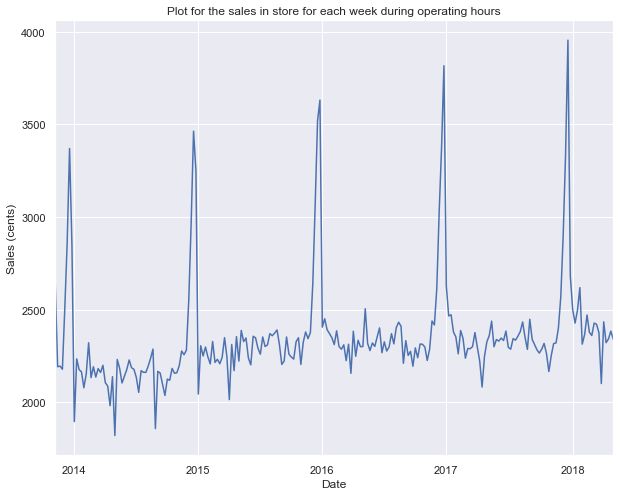

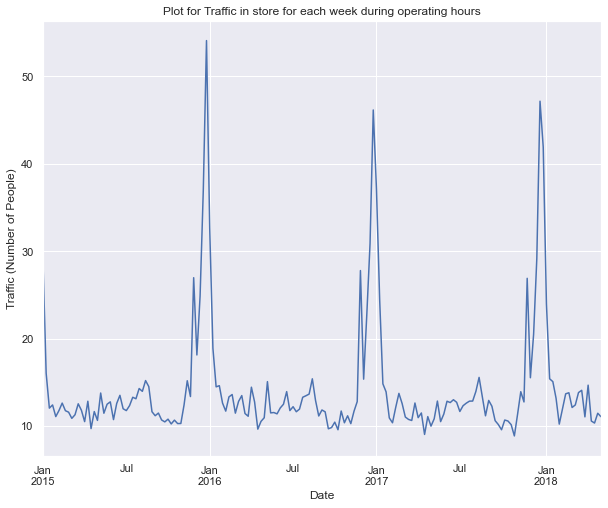

In [45]:
#Weekly sales and Traffic plot
weekly_sketch_sales = df_sales_temp.copy()
weekly_sketch_sales.set_index(["Date"], inplace=True)
df_sales_weekly = weekly_sketch_sales.resample('W').mean()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 8)
ax.set_ylabel("Sales (cents)")
ax.set_xlabel("Date and Time of the sales (Week)")
ax.set_title("Plot for the sales in store for each week during operating hours")
df_sales_weekly["Sales_cents"].plot(ax=ax)
plt.show()

weekly_sketch_traffic = df_traffic_temp.copy()
weekly_sketch_traffic.set_index(["Date"], inplace=True)
df_traffic_weekly = weekly_sketch_traffic.resample('W').mean()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)
ax.set_ylabel("Traffic (Number of People)")
ax.set_xlabel("Date and Time of the sales (Week)")
ax.set_title("Plot for Traffic in store for each week during operating hours")
df_traffic_weekly["No_people"].plot(ax=ax)
plt.show()


##### Testing for Stationarity

ADF hypothesis
- Null Hypothesis $(H_0)$: The series has a unit root (Not Stationary)
- Alternate Hypothesis $(H_a)$: The series has no unit root (Stationary)

KPSS hypothesis
- Null Hypothesis $(H_0)$: The process is trend stationary.
- Alternate Hypothesis $(H_a)$: The series has a unit root (series is not stationary)


Case 1: Both tests conclude that the series is not stationary - The series is not stationary <br>
Case 2: Both tests conclude that the series is stationary - The series is stationary<br>
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.<br>
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.<br>

    If it isn’t stationary, we make it stationary
        - Introduce a difference (subtract from itself with a lag)
        - smoothing, trend & seasonality removal (time-series decomposition)
        - log transforms
        - box-cox transform

link:https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [46]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(timeseries,name):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=["Test Statistic","p-value","#Lags Used","Number of Observations Used",],)
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    results = pd.DataFrame(dfoutput).rename(columns={0:f"ADF {name} results"})
    return results
    
def kpss_test(timeseries,name):
    kpsstest = kpss(timeseries, nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    results = pd.DataFrame(kpss_output).rename(columns={0:f"KPSS {name} results"})
    return results

In [47]:
#Sales testing ADF
sales_testing = df_sales_temp.set_index("Date")
adf_test(sales_testing[["Sales_cents"]],"Sales")

,ADF Sales results
Test Statistic,-1.494710e+01
p-value,1.296729e-27
#Lags Used,4.600000e+01
Number of Observations Used,2.309800e+04
Critical Value (1%),-3.430633e+00
Critical Value (5%),-2.861665e+00
Critical Value (10%),-2.566837e+00


In [48]:
#Sales testing KPSS
kpss_test(sales_testing[["Sales_cents"]],"Sales")

,KPSS Sales results
Test Statistic,0.428168
p-value,0.065014
Lags Used,1704.000000
Critical Value (10%),0.347000
Critical Value (5%),0.463000
Critical Value (2.5%),0.574000
Critical Value (1%),0.739000


In [49]:
#Traffic testing ADF
traffic_testing = df_traffic_temp.set_index("Date")
adf_test(traffic_testing[["No_people"]],"Traffic")


,ADF Traffic results
Test Statistic,-1.218724e+01
p-value,1.310226e-22
#Lags Used,4.400000e+01
Number of Observations Used,1.719300e+04
Critical Value (1%),-3.430730e+00
Critical Value (5%),-2.861708e+00
Critical Value (10%),-2.566859e+00


In [50]:
#Traffic KPSS test
kpss_test(traffic_testing[["No_people"]],"Traffic")

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,KPSS Traffic results
Test Statistic,0.31247
p-value,0.10000
Lags Used,44.00000
Critical Value (10%),0.34700
Critical Value (5%),0.46300
Critical Value (2.5%),0.57400
Critical Value (1%),0.73900


Both the ADF Tests , $p-value<0.05$ which implies that the null hypothesis is rejected. Thus, the series is stationary according to the ADF. Similarly to the KPSS Tests, they suggest that we fail to reject the null hypothesis which implies that there series are stationary. 

The results show that both the series are statonary though there plot shows some anual seasonality. The augmented Dickey-Fuller (ADF) test and the Kwiatkowski, Phillips, Schmidt, and Shin (KPSS) test are both designed to detect nonstationarity in the form of a process unit root. They are not, however, designed to detect other types of nonstationarity. As a result, it is not surprising that they do not identify seasonal nonstationarity.


    Time series decompsition

Components:
 - **Cyclical**: This is cyclical, but it does not occur on a definite timescale. For instance, stock market crashes and boom times. Normally, this is incorporated into the trend component.
 - **Trend**: Is there a general trend in the data (good or negative), regardless of time period? This is the series' low frequency component.

 - **Seasonality**: There are patterns in the data that appear at regular intervals (day, month, quarter, etc). Because a dataset can contain numerous "seasons," this feature is more involved than it appears at first.

 - **Noise**: unpredictable, irregular components in the data that cannot be explained by trends or seasonality

The plots above show that the seasonality does not change overtime (Cyclical), impies that the decomposition model is additive.

Link: If the magnitude of the seasonal component changes with time, then the series is multiplicative. Otherwise, the series is additive.
https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693

The results show that the trend is more like the same with the actual plot which indicates that the trend in this series is more prominant as there's no seasonality.

When removing the seasonality from the additive model, there's no difference as can be seen on the plots that there's no difference in from the original plot and the one with seasonality removed.


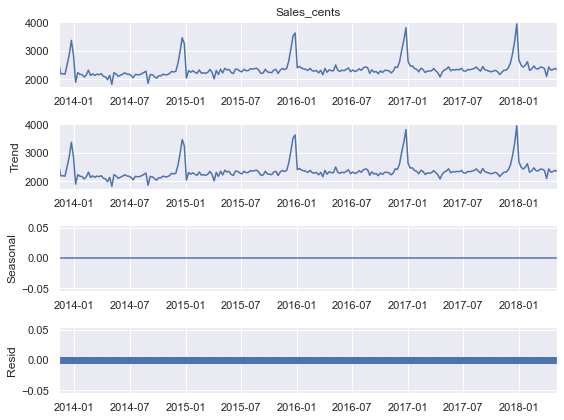

In [51]:
#Time series decomposition for Sales
from statsmodels.tsa.seasonal import seasonal_decompose
temp_1 = df_sales_temp.set_index("Date").resample('W').mean()
sales_decompose = seasonal_decompose(temp_1["Sales_cents"], model="additive",period=1)
fig =sales_decompose.plot()
fig.set_size_inches((8,6))
fig.tight_layout()

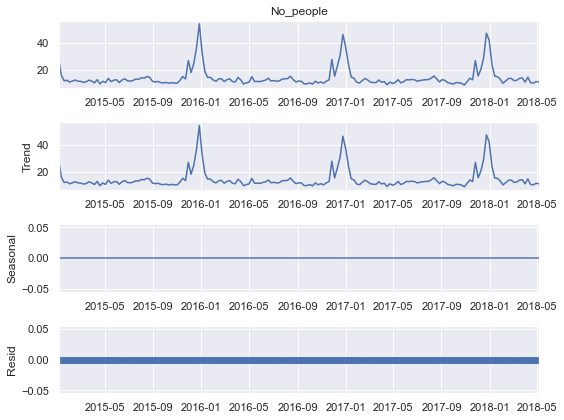

In [52]:
#Time series decomposition for Traffic (Optional_The tests show that this is stationary)
temp_2 = df_traffic_temp.set_index("Date").resample('W').mean()
traffic_decompose = seasonal_decompose(temp_2["No_people"], model="additive",period=1)
fig =traffic_decompose.plot()
fig.set_size_inches((8,6))
fig.tight_layout()

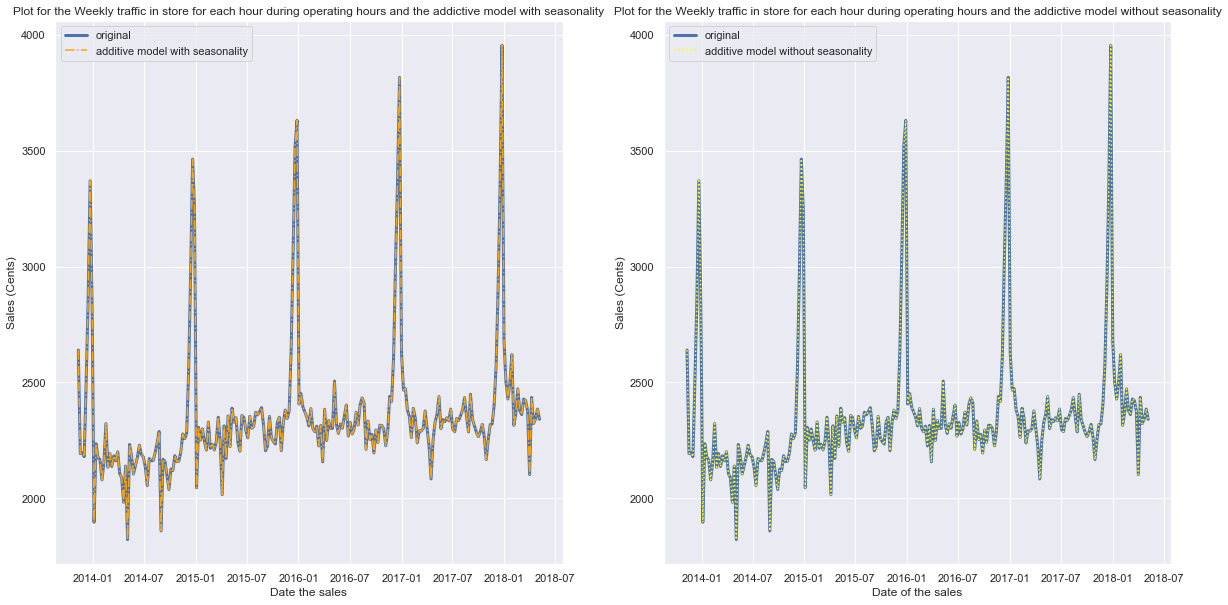

In [53]:
#Additive model for Sales
df_tmp = sales_decompose.seasonal + sales_decompose.trend + sales_decompose.resid
df_tmp=pd.DataFrame(df_tmp).rename(columns={0:"Sales_cents"})

df_tmp_11 = sales_decompose.trend + sales_decompose.resid - sales_decompose.seasonal
df_tmp_11=pd.DataFrame(df_tmp_11).rename(columns={0:"Sales_cents"})

fig, (with_stat,without_stat) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
with_stat.plot(temp_1['Sales_cents'], label='original', linewidth=3)
with_stat.plot(df_tmp['Sales_cents'], color='orange', linestyle='dashdot', label='additive model with seasonality')
with_stat.set_title("Plot for the Weekly traffic in store for each hour during operating hours and the addictive model with seasonality")
with_stat.set_xlabel("Date the sales")
with_stat.set_ylabel("Sales (Cents)")
with_stat.legend()

without_stat.plot(temp_1['Sales_cents'],  label='original',linewidth=3)
without_stat.plot(df_tmp_11['Sales_cents'], color='yellow', linestyle='dotted', label='additive model without seasonality')
without_stat.set_title("Plot for the Weekly traffic in store for each hour during operating hours and the addictive model without seasonality")
without_stat.set_xlabel("Date of the sales")
without_stat.set_ylabel("Sales (Cents)")
without_stat.legend()

plt.show()


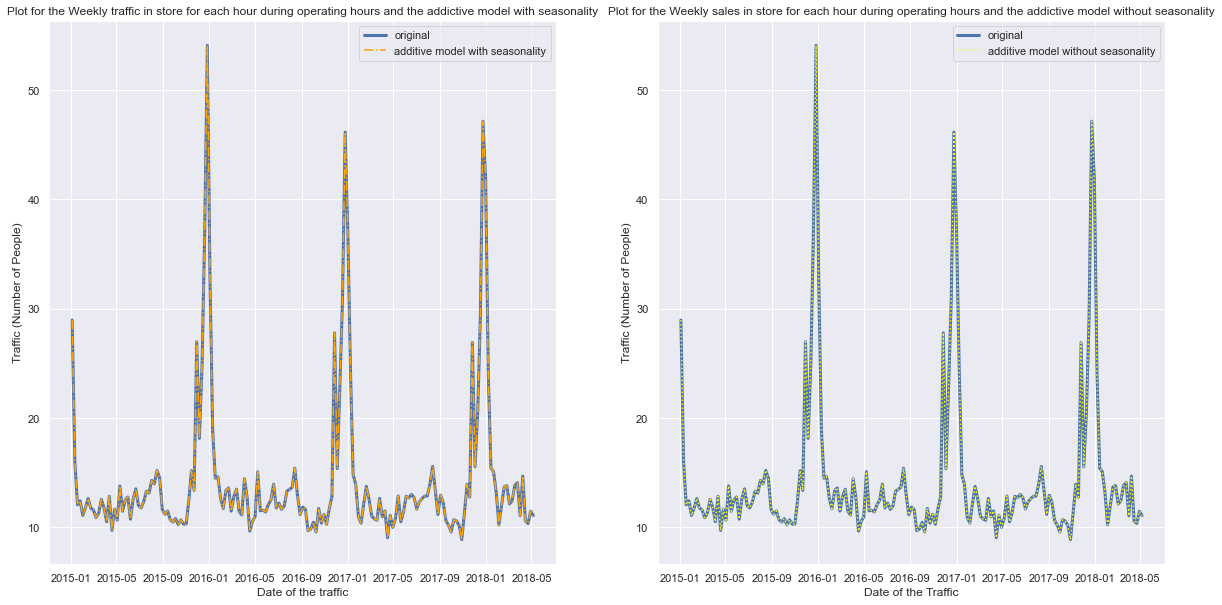

In [54]:
#Additive model for Traffic 
df_tmp_2 = traffic_decompose.seasonal + traffic_decompose.trend + traffic_decompose.resid
df_tmp_2=pd.DataFrame(df_tmp_2).rename(columns={0:"No_people"})

df_tmp_22 = traffic_decompose.trend + traffic_decompose.resid - traffic_decompose.seasonal
df_tmp_22=pd.DataFrame(df_tmp_22).rename(columns={0:"No_people"})

fig, (with_stat,without_stat) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
with_stat.plot(temp_2['No_people'], label='original', linewidth=3)
with_stat.plot(df_tmp_2['No_people'], color='orange', linestyle='dashdot', label='additive model with seasonality')
with_stat.set_title("Plot for the Weekly traffic in store for each hour during operating hours and the addictive model with seasonality")
with_stat.set_xlabel("Date of the traffic")
with_stat.set_ylabel("Traffic (Number of People)")
with_stat.legend()

without_stat.plot(temp_2['No_people'],  label='original',linewidth=3)
without_stat.plot(df_tmp_22['No_people'], color='yellow', linestyle='dotted', label='additive model without seasonality')
without_stat.set_title("Plot for the Weekly sales in store for each hour during operating hours and the addictive model without seasonality")
without_stat.set_xlabel("Date of the Traffic")
without_stat.set_ylabel("Traffic (Number of People)")
without_stat.legend()

plt.show()


As can be seen from the previous plots that removing seasonality in the model has no effect. Answers was posted on a forum reffrering to different articles answering whether seasonality implies non-stationarity.

    Answers: 
        - Seasonality means that the series goes up and down around a constant value....something like a sine wave. So by this logic a time series with seasonality is a (weakly) stationary series (constant mean).
        - A stable seasonal pattern is not stationary in the sense that the mean of the series will vary across seasons and, hence, depends on time; but it is stationary in the sense that we can expect the same mean for the same month in different years.

link: https://stats.stackexchange.com/questions/131092/does-a-seasonal-time-series-imply-a-stationary-or-a-non-stationary-time-series

<center>Applying different transformations to capture seasonality</center>

    This case does not require the cases mentioned as it shows that the tests passed that the series are stationary. Thus I applied different transformation for capturing seasonality
        - Differencing
        - Square Root Transform
        - Log Transform



In [55]:
from scipy import stats

#Sales
df_stationary_sales = df_sales_temp.copy()
df_stationary_sales.set_index(["Date"], inplace=True)

df_stationary_sales["stationary_diff"] = df_stationary_sales["Sales_cents"]-df_stationary_sales["Sales_cents"].shift(1) 
df_stationary_sales["stationary_sqrt"] = np.sqrt(df_stationary_sales["Sales_cents"]) 
df_stationary_sales["stationary_log"]= np.log(df_stationary_sales["Sales_cents"]+1) #Add 1 for smoothing for log transform to overcome infinity
df_stationary_sales_weekly = df_stationary_sales.resample('W').mean()


#Traffic
df_stationary_traffic = df_traffic_temp.copy()
df_stationary_traffic.set_index(["Date"], inplace=True)

df_stationary_traffic["stationary_diff"] = df_stationary_traffic["No_people"]-df_stationary_traffic["No_people"].shift(1) 
df_stationary_traffic["stationary_sqrt"] = np.sqrt(df_stationary_traffic["No_people"]) 
df_stationary_traffic["stationary_log"]= np.log(df_stationary_traffic["No_people"]+1) #Add 1 for smoothing for log transform to overcome infinity
df_stationary_traffic_weekly = df_stationary_traffic.resample('W').mean()

In [56]:
# Overview of the transformed series (Traffic) 
df_stationary_traffic

,No_people,Events_holidays,Season,stationary_diff,stationary_sqrt,stationary_log
Date,,,,,,
2015-01-01 10:00:00,8.0,1,3,NaN,2.828427,2.197225
2015-01-01 11:00:00,14.0,1,3,6.0,3.741657,2.708050
2015-01-01 12:00:00,28.0,1,3,14.0,5.291503,3.367296
2015-01-01 13:00:00,33.0,1,3,5.0,5.744563,3.526361
2015-01-01 14:00:00,47.0,1,3,14.0,6.855655,3.871201
...,...,...,...,...,...,...
2018-05-06 15:00:00,41.0,0,1,-1.0,6.403124,3.737670
2018-05-06 16:00:00,33.0,0,1,-8.0,5.744563,3.526361
2018-05-06 17:00:00,27.0,0,1,-6.0,5.196152,3.332205


In [57]:
# Overview of the transformed series (sales) 
df_stationary_sales

,Sales_cents,Events_holidays,Season,stationary_diff,stationary_sqrt,stationary_log
Date,,,,,,
2013-11-07 13:00:00,3457.0,0,1,NaN,58.796258,8.148446
2013-11-07 14:00:00,2250.0,0,1,-1207.0,47.434165,7.719130
2013-11-07 15:00:00,0.0,0,1,-2250.0,0.000000,0.000000
2013-11-07 16:00:00,729.0,0,1,729.0,27.000000,6.593045
2013-11-07 17:00:00,0.0,0,1,-729.0,0.000000,0.000000
...,...,...,...,...,...,...
2018-05-06 15:00:00,3645.0,0,1,-131.0,60.373835,8.201386
2018-05-06 16:00:00,3372.0,0,1,-273.0,58.068925,8.123558
2018-05-06 17:00:00,3077.0,0,1,-295.0,55.470713,8.032035


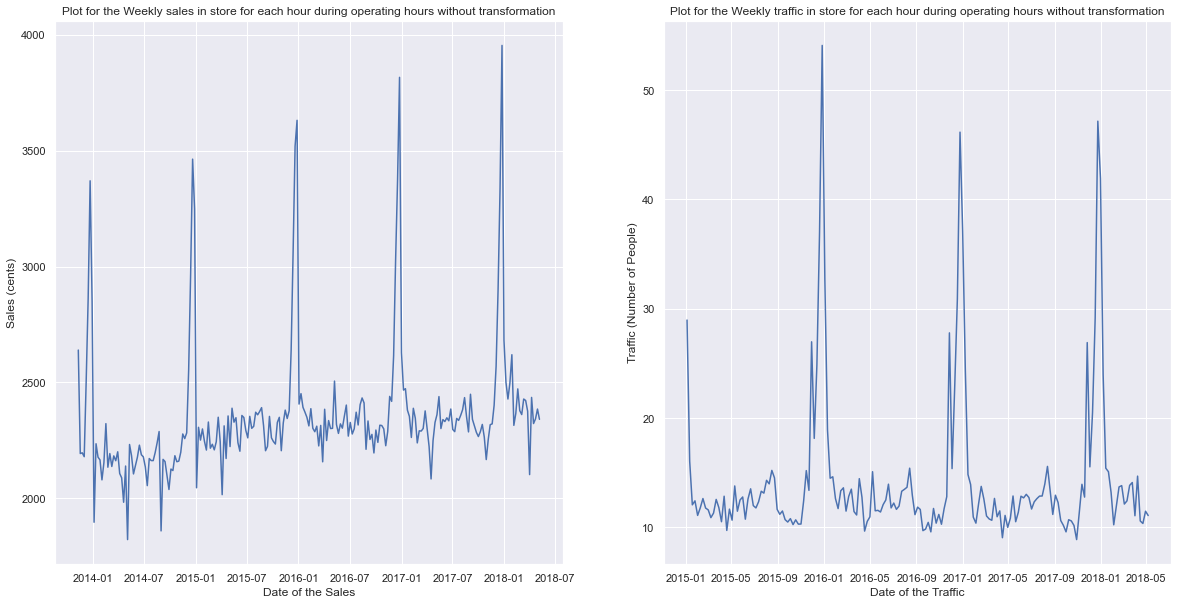

In [58]:
#Original Sales and Traffic
fig, (sales_axis,traffic_axis) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(df_stationary_sales_weekly['Sales_cents'])
sales_axis.set_title("Plot for the Weekly sales in store for each hour during operating hours without transformation")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")


traffic_axis.plot(df_stationary_traffic_weekly['No_people'])
traffic_axis.set_title("Plot for the Weekly traffic in store for each hour during operating hours without transformation")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic (Number of People)")



plt.show()




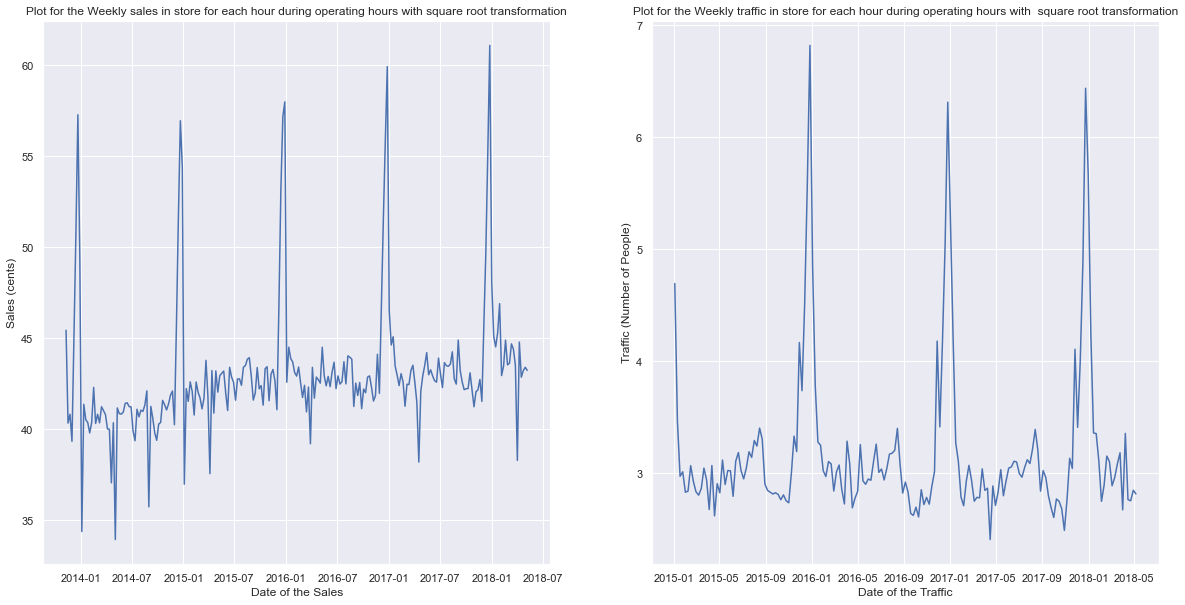

In [59]:
# Sales and Traffic with transformation (Square root)
fig, (sales_axis,traffic_axis) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(df_stationary_sales_weekly['stationary_sqrt'])
sales_axis.set_title("Plot for the Weekly sales in store for each hour during operating hours with square root transformation")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")


traffic_axis.plot(df_stationary_traffic_weekly['stationary_sqrt'])
traffic_axis.set_title("Plot for the Weekly traffic in store for each hour during operating hours with  square root transformation")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic (Number of People)")


plt.show()

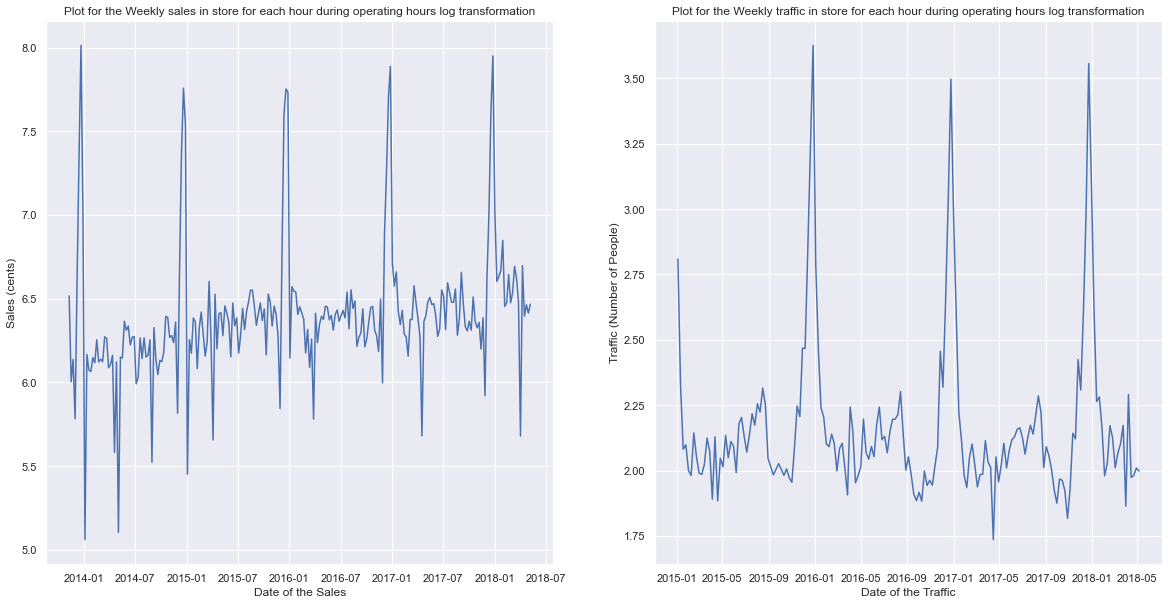

In [60]:
# Sales and Traffic with transformation (Log)
fig, (sales_axis,traffic_axis) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(df_stationary_sales_weekly['stationary_log'])
sales_axis.set_title("Plot for the Weekly sales in store for each hour during operating hours log transformation")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")

traffic_axis.plot(df_stationary_traffic_weekly['stationary_log'])
traffic_axis.set_title("Plot for the Weekly traffic in store for each hour during operating hours log transformation")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic (Number of People)")

plt.show()

    After applying different transforms to the  series, it  is clear that the seasonality cannot be removed from the data as it is constant and it will contribute toward the forecasting of the model(s)-Seasonal Cycle

## <CENTER> 3. Model Building </CENTER>

#### This Section will focus on :

        - Building Machine Learning models
        - Model Validation and Model Selection

**Note**: The models will be build on two series, the one with timestamp as index and the one with features of the time stamp

Derivative of features from the actual time stamp as some models are not of Time series.


In [61]:
#Method for adding fatures in the dataframe
def derive_features_from_timestamp(datframe):
    datframe = datframe.copy()
    datframe['hour'] = datframe.index.hour
    datframe['dayofweek'] = datframe.index.dayofweek
    datframe['quarter'] = datframe.index.quarter
    datframe['month'] = datframe.index.month
    datframe['year'] = datframe.index.year
    datframe['dayofyear'] = datframe.index.dayofyear
    datframe['dayofmonth'] = datframe.index.day
    datframe['weekofyear'] = datframe.index.isocalendar().week

    return datframe


In [62]:
#Adding features in the datasets
df_sales_temp_2 = df_sales_temp.copy() #Copy 
df_traffic_temp_2 = df_traffic_temp.copy()

df_sales_temp_2.set_index("Date", inplace=True)
df_traffic_temp_2.set_index("Date", inplace=True)

df_sales_temp_2 = derive_features_from_timestamp(df_sales_temp_2)
df_traffic_temp_2= derive_features_from_timestamp(df_traffic_temp_2)

df_sales_temp_2['weekofyear'] = pd.to_numeric(df_sales_temp_2['weekofyear'], errors="coerce").fillna(0).astype('int64')
df_traffic_temp_2['weekofyear'] = pd.to_numeric(df_traffic_temp_2['weekofyear'], errors="coerce").fillna(0).astype('int64')


<Center> Data Spliting for validating the Model's ability for forecasting future sales and traffic </center>

In [63]:
from sklearn.model_selection import TimeSeriesSplit

X_sales = df_sales_temp[["Date","Events_holidays","Season"]]
y_sales = df_sales_temp[["Sales_cents"]] #Sales_cents

X_traffic = df_traffic_temp[["Date","Events_holidays","Season"]]
y_traffic = df_traffic_temp[["No_people"]]
tscv = TimeSeriesSplit(2)

test_indexes_sales = []
test_indexes_traffic= []
train_indexes_sales = []
train_indexes_traffic= []

for train_index, test_index in tscv.split(X_sales):
    X_train_sales, X_test_sales = X_sales.iloc[train_index], X_sales.iloc[test_index]
    y_train_sales, y_test_sales = y_sales.iloc[train_index], y_sales.iloc[test_index]
    test_indexes_sales = test_index
    train_indexes_traffic = train_index
    

for train_index, test_index in tscv.split(X_traffic):
    X_train_traffic, X_test_traffic = X_traffic.iloc[train_index], X_traffic.iloc[test_index]
    y_train_traffic, y_test_traffic = y_traffic.iloc[train_index], y_traffic.iloc[test_index]
    test_indexes_traffic = test_index
    train_indexes_traffic = train_index

test_df_sales = df_sales_temp.iloc[test_indexes_sales]
train_df_sales = df_sales_temp.iloc[train_indexes_sales]


test_df_traffic = df_traffic_temp.iloc[test_indexes_traffic]
train_df_traffic = df_traffic_temp.iloc[train_indexes_traffic]

In [64]:
#Splitting for the 2 series where the datetime is separated
explanatory_vars = ["Events_holidays","Season",	"hour",	"dayofweek","quarter","month","year","dayofyear","dayofmonth","weekofyear"]
predict_var_sales= 'Sales_cents'
predict_var_traffic = "No_people"

X_sales_2 = df_sales_temp_2[explanatory_vars]
y_sales_2 = df_sales_temp_2[[predict_var_sales]] #Sales_cents

X_traffic_2 = df_traffic_temp_2[explanatory_vars]
y_traffic_2 = df_traffic_temp_2[[predict_var_traffic]]
tscv_2 = TimeSeriesSplit(2)

test_indexes_sales_2 = []
test_indexes_traffic_2= []
train_indexes_sales_2 = []
train_indexes_traffic_2= []

for train_index, test_index in tscv_2.split(X_sales_2):
    X_train_sales_2, X_test_sales_2 = X_sales_2.iloc[train_index], X_sales_2.iloc[test_index]
    y_train_sales_2, y_test_sales_2 = y_sales_2.iloc[train_index], y_sales_2.iloc[test_index]
    test_indexes_sales_2 = test_index

for train_index, test_index in tscv_2.split(X_traffic_2):
    X_train_traffic_2, X_test_traffic_2 = X_traffic_2.iloc[train_index], X_traffic_2.iloc[test_index]
    y_train_traffic_2, y_test_traffic_2 = y_traffic_2.iloc[train_index], y_traffic_2.iloc[test_index]
    test_indexes_traffic_2 = test_index

test_df_sales_2 = df_sales_temp.iloc[test_indexes_sales]
test_df_traffic_2 = df_traffic_temp.iloc[test_indexes_traffic]
train_df_sales_2 = df_sales_temp.iloc[train_indexes_sales_2]
train_df_traffic_2 = df_traffic_temp.iloc[train_indexes_traffic_2]

<center>Machine learning Models to train</center>
    
- Linear Regression
- XGboost
- Random Forest
- FBProphet
- SARIMAX

    Note: Some of this algorithms does not requre the series to be stationary as they perfom it. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

In [65]:
df_sales_temp

,Date,Sales_cents,Events_holidays,Season
0,2013-11-07 13:00:00,3457.0,0,1
1,2013-11-07 14:00:00,2250.0,0,1
2,2013-11-07 15:00:00,0.0,0,1
3,2013-11-07 16:00:00,729.0,0,1
4,2013-11-07 17:00:00,0.0,0,1
...,...,...,...,...
39386,2018-05-06 15:00:00,3645.0,0,1
39387,2018-05-06 16:00:00,3372.0,0,1
39388,2018-05-06 17:00:00,3077.0,0,1
39389,2018-05-06 18:00:00,3190.0,0,1


    Linear Regression

 - Comparing the two models (Linear Regression), The results show that the model with the datetime separeated is is more robust than the one with only two features as the metrics show and the plot/fitted models show that the one with more features tends to be sensitive to change 

a. Linear regression with holiday and season as features

In [66]:
#No separating the Date time field
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error,mean_absolute_error,mean_absolute_error

#Sales
LR_train_sales = X_train_sales.copy()
LR_train_sales["Date"]=X_train_sales.index

LR_test_sales = X_test_sales.copy()
LR_test_sales["Date"]=X_test_sales.index

LR_model_sales = LinearRegression(fit_intercept=True)
LR_model_sales.fit(LR_train_sales, y_train_sales)
y_predicted_sales = LR_model_sales.predict(LR_test_sales)

#Traffic 
LR_train_traffic = X_train_traffic.copy()
LR_train_traffic["Date"]=X_train_traffic.index

LR_test_traffic = X_test_traffic.copy()
LR_test_traffic["Date"]=X_test_traffic.index

LR_model_traffic = LinearRegression(fit_intercept=True)
LR_model_traffic.fit(LR_train_traffic, y_train_traffic)
y_predicted_traffic = LR_model_traffic.predict(LR_test_traffic)

#Validating model
print(f"Linear Regression for Sales Mean Absolute Error(MAE): {mean_absolute_error (y_test_sales, y_predicted_sales)}")
print(f"Linear Regression for Sales Mean Square Error(MSE): {mean_squared_error (y_test_sales, y_predicted_sales)}")
print(f"Linear Regression for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (y_test_sales, y_predicted_sales))}")

print(f"\nLinear Regression for Traffic Mean Absolute Error(MAE): {mean_absolute_error (y_test_traffic, y_predicted_traffic)}")
print(f"Linear Regression for Traffic Mean Square Error(MSE): {mean_squared_error (y_test_traffic, y_predicted_traffic)}")
print(f"Linear Regression for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (y_test_traffic, y_predicted_traffic))}")


Linear Regression for Sales Mean Absolute Error(MAE): 1102.706516983159
Linear Regression for Sales Mean Square Error(MSE): 1804533.0160601302
Linear Regression for Sales Root mean square Error(RMSE): 1343.3290795855385

Linear Regression for Traffic Mean Absolute Error(MAE): 10.872041063031244
Linear Regression for Traffic Mean Square Error(MSE): 211.67810697756957
Linear Regression for Traffic Root mean square Error(RMSE): 14.54916172765873


b. Linear regressiuon with extra features

In [67]:
# Modelling with extra features in the series
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error,mean_absolute_error,mean_absolute_error

#Sales
LR_train_sales_2 = X_train_sales_2.copy()
LR_test_sales_2 = X_test_sales_2.copy()

LR_model_sales_2 = LinearRegression(fit_intercept=True)
LR_model_sales_2.fit(LR_train_sales_2, y_train_sales_2)
y_predicted_sales_2= LR_model_sales_2.predict(LR_test_sales_2)

#Traffic 
LR_train_traffic_2 = X_train_traffic_2.copy()

LR_test_traffic_2 = X_test_traffic_2.copy()

LR_model_traffic_2 = LinearRegression(fit_intercept=True)
LR_model_traffic_2.fit(LR_train_traffic_2, y_train_traffic)
y_predicted_traffic_2= LR_model_traffic_2.predict(LR_test_traffic_2)

#Validating model
print(f"Linear Regression (Extra Features) for Sales Mean Absolute Error(MAE): {mean_absolute_error (y_test_sales_2, y_predicted_sales_2)}")
print(f"Linear Regression (Extra Features) for Sales Mean Square Error(MSE): {mean_squared_error (y_test_sales_2, y_predicted_sales_2)}")
print(f"Linear Regression (Extra Features) for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (y_test_sales_2, y_predicted_sales_2))}")

print(f"\nLinear Regression (Extra Features) for Traffic Mean Absolute Error(MAE): {mean_absolute_error (y_test_traffic_2, y_predicted_traffic_2)}")
print(f"Linear Regression (Extra Features) for Traffic Mean Square Error(MSE): {mean_squared_error (y_test_traffic_2, y_predicted_traffic_2)}")
print(f"Linear Regression (Extra Features) for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (y_test_traffic_2, y_predicted_traffic_2))}")



Linear Regression (Extra Features) for Sales Mean Absolute Error(MAE): 1035.369821422665
Linear Regression (Extra Features) for Sales Mean Square Error(MSE): 1778306.9822728545
Linear Regression (Extra Features) for Sales Root mean square Error(RMSE): 1333.531770252533

Linear Regression (Extra Features) for Traffic Mean Absolute Error(MAE): 9.797623576185165
Linear Regression (Extra Features) for Traffic Mean Square Error(MSE): 174.4038683243773
Linear Regression (Extra Features) for Traffic Root mean square Error(RMSE): 13.20620567477189


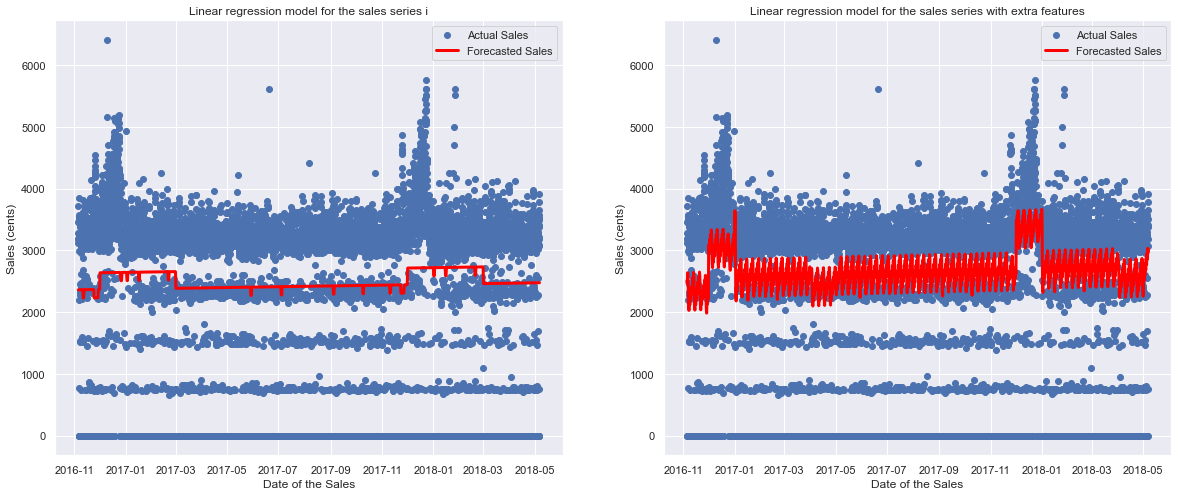

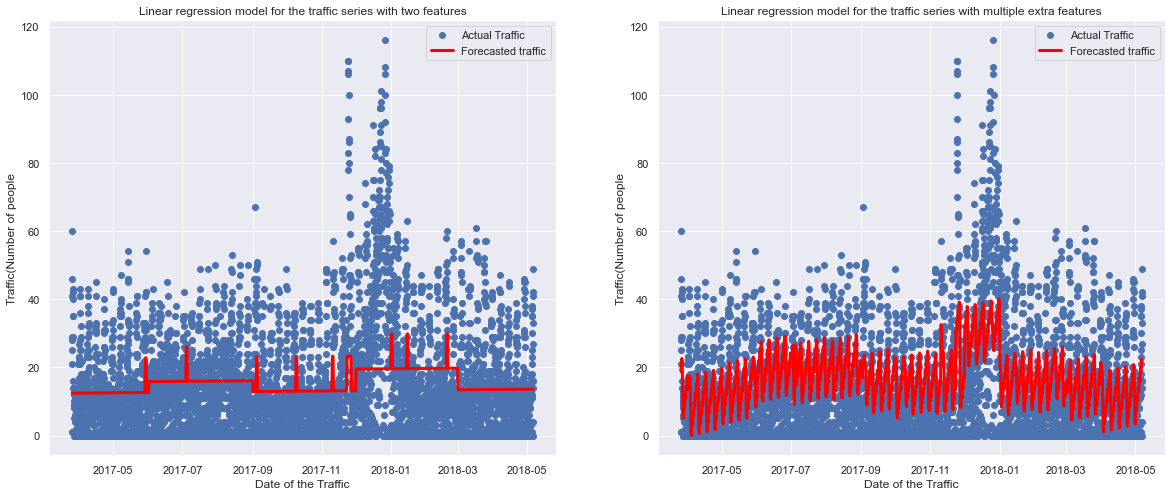

In [68]:
#Plots for the predicted data points and actual points


#Plotting fitted model for Sales with extra features and multiple features
LR_sales_results = X_test_sales.copy()
LR_sales_results["Predicted"]=y_predicted_sales
LR_sales_results["actual"]= y_test_sales["Sales_cents"]
LR_sales_results.drop(columns = ["Events_holidays","Season"], inplace=True)
LR_sales_results.set_index("Date", inplace=True)

LR_sales_results_2 = X_test_sales_2.copy()
LR_sales_results_2["Predicted"]=y_predicted_sales_2
LR_sales_results_2["actual"]= y_test_sales_2["Sales_cents"]
LR_sales_results_2.drop(columns = explanatory_vars, inplace=True)

fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,8))
sales_axis.scatter(x=LR_sales_results.index, y=LR_sales_results.actual, label="Actual points")
sales_axis.plot(LR_sales_results.Predicted, linewidth=3, color="red", label="Fitted Model")
sales_axis.set_title("Linear regression model for the sales series i")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")
sales_axis.legend(["Actual Sales","Forecasted Sales"])

sales_axis_2.scatter(x=LR_sales_results_2.index, y=LR_sales_results_2.actual, label="Actual points")
sales_axis_2.plot(LR_sales_results_2.Predicted, linewidth=3, color="red", label="Fitted Model")
sales_axis_2.set_title("Linear regression model for the sales series with extra features")
sales_axis_2.set_xlabel("Date of the Sales")
sales_axis_2.set_ylabel("Sales (cents)")
sales_axis_2.legend(["Actual Sales","Forecasted Sales"])
plt.show()



#Plotting fitted model for traffic with extra features and multiple features
LR_traffic_results = X_test_traffic.copy()
LR_traffic_results["Predicted"]=y_predicted_traffic
LR_traffic_results["actual"]= y_test_traffic["No_people"]
LR_traffic_results.drop(columns = ["Events_holidays","Season"], inplace=True)
LR_traffic_results.set_index("Date", inplace=True)

LR_traffic_results_2 = X_test_traffic_2.copy()
LR_traffic_results_2["Predicted"]=y_predicted_traffic_2
LR_traffic_results_2["actual"]= y_test_traffic_2["No_people"]
LR_traffic_results_2.drop(columns = explanatory_vars, inplace=True)

fig, (traffic_axis,traffic_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,8))
traffic_axis.scatter(x=LR_traffic_results.index, y=LR_traffic_results.actual, label="Actual points")
traffic_axis.plot(LR_traffic_results.Predicted, linewidth=3, color="red", label="Fitted Model")
traffic_axis.set_title("Linear regression model for the traffic series with two features")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic(Number of people")
traffic_axis.legend(["Actual Traffic","Forecasted traffic"])

traffic_axis_2.scatter(x=LR_traffic_results_2.index, y=LR_traffic_results_2.actual, label="Actual points")
traffic_axis_2.plot(LR_traffic_results_2.Predicted, linewidth=3, color="red", label="Fitted Model")
traffic_axis_2.set_title("Linear regression model for the traffic series with multiple extra features")
traffic_axis_2.set_xlabel("Date of the Traffic")
traffic_axis_2.set_ylabel("Traffic(Number of people")
traffic_axis_2.legend(["Actual Traffic","Forecasted traffic"])
plt.show()



The Linear regression models metrics show that they are in accurate when forecasting and they are not to senstitive to seasonality especially with the model having only few features. Comparing the two models, the models with multiple explanatory variables seem to be better than the ones with only two explanatory features (Holidays and season). 


    XGboost
- The metrics of the models with multiple features seems to be desirable in tgis algorithm also as they rmse is lower compared to teh one of the model using two features 

a. Two features

In [69]:
#Sales
from xgboost import XGBRegressor
reg_sales = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear', #tells it to use sum of squared error to inform its fit on a regression problem
                       max_depth=3,
                       verbosity = 0,
                       early_stopping_rounds=50, #To avoid overfitting
                       learning_rate=0.01)

reg_sales.fit(X_train_sales.set_index("Date"), y_train_sales,eval_set=[(X_train_sales.set_index("Date"), y_train_sales), (X_test_sales.set_index("Date"), y_test_sales)],verbose=100)

[0]	validation_0-rmse:2644.72119	validation_1-rmse:2766.65381
[100]	validation_0-rmse:1570.16370	validation_1-rmse:1648.31750
[200]	validation_0-rmse:1363.19580	validation_1-rmse:1406.56482
[300]	validation_0-rmse:1333.01709	validation_1-rmse:1360.61951
[400]	validation_0-rmse:1328.91235	validation_1-rmse:1350.53442
[500]	validation_0-rmse:1328.36523	validation_1-rmse:1347.77930
[600]	validation_0-rmse:1328.28772	validation_1-rmse:1346.89636
[700]	validation_0-rmse:1328.27722	validation_1-rmse:1346.58777
[800]	validation_0-rmse:1328.27673	validation_1-rmse:1346.47803
[900]	validation_0-rmse:1328.27417	validation_1-rmse:1346.43823
[999]	validation_0-rmse:1328.28113	validation_1-rmse:1346.42346


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=0)

In [70]:
#Importance of each feature in the series of sales ahow that the season is more important than Events and holidays
reg_sales.feature_importances_
feature_important_sales = pd.DataFrame(data=reg_sales.feature_importances_,columns=["Importance"],index=["Events_holidays","Season"])
feature_important_sales

,Importance
Events_holidays,0.047628
Season,0.952372


In [71]:
#Traffic
reg_traffic = XGBRegressor(base_score=0.5,   
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg_traffic.fit(X_train_traffic.set_index("Date"), y_train_traffic,
        eval_set=[(X_train_traffic.set_index("Date"), y_train_traffic), (X_test_traffic.set_index("Date"), y_test_traffic)],
        verbose=100)

[0]	validation_0-rmse:20.34904	validation_1-rmse:20.10283
[100]	validation_0-rmse:15.60272	validation_1-rmse:15.42754
[200]	validation_0-rmse:14.85070	validation_1-rmse:14.60461
[300]	validation_0-rmse:14.74691	validation_1-rmse:14.46001
[400]	validation_0-rmse:14.73287	validation_1-rmse:14.42923
[500]	validation_0-rmse:14.73100	validation_1-rmse:14.42099
[600]	validation_0-rmse:14.73075	validation_1-rmse:14.41836
[700]	validation_0-rmse:14.73072	validation_1-rmse:14.41747
[800]	validation_0-rmse:14.73072	validation_1-rmse:14.41714
[900]	validation_0-rmse:14.73072	validation_1-rmse:14.41702
[999]	validation_0-rmse:14.73066	validation_1-rmse:14.41696


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

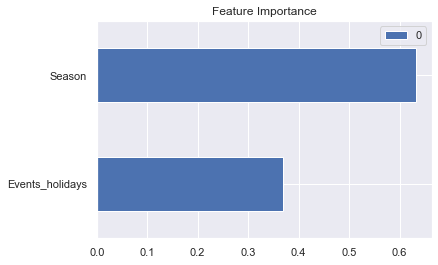

In [72]:
#Importance of each feature in the series of Traffic show that the season is more important than Events and holidays
reg_traffic.feature_importances_
feature_important_traffic = pd.DataFrame(data=reg_traffic.feature_importances_,index=["Events_holidays","Season"])
feature_important_traffic.plot(kind='barh', title='Feature Importance')
plt.show()

b. Multiple Features

In [73]:
#Sales
from xgboost import XGBRegressor
reg_sales_2 = XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear', #tells it to use sum of squared error to inform its fit on a regression problem
                       max_depth=3,
                       verbosity = 0,
                       early_stopping_rounds=50, #To avoid overfitting
                       learning_rate=0.01)

reg_sales_2.fit(X_train_sales_2, y_train_sales_2,eval_set=[(X_train_sales_2, y_train_sales_2), (X_test_sales_2, y_test_sales_2)],verbose=100)

[0]	validation_0-rmse:2639.81372	validation_1-rmse:2762.08472
[100]	validation_0-rmse:1145.20142	validation_1-rmse:1253.84863
[200]	validation_0-rmse:685.81177	validation_1-rmse:766.80487
[300]	validation_0-rmse:569.09155	validation_1-rmse:623.69128
[400]	validation_0-rmse:528.91449	validation_1-rmse:568.52502
[500]	validation_0-rmse:507.21182	validation_1-rmse:540.50348
[600]	validation_0-rmse:495.87927	validation_1-rmse:528.43073
[700]	validation_0-rmse:488.71582	validation_1-rmse:522.94885
[800]	validation_0-rmse:483.48730	validation_1-rmse:518.86371
[900]	validation_0-rmse:479.05115	validation_1-rmse:514.63415
[999]	validation_0-rmse:474.49969	validation_1-rmse:511.69760


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=0)

The most important feature in this model is the hour at which the sales were made at the store

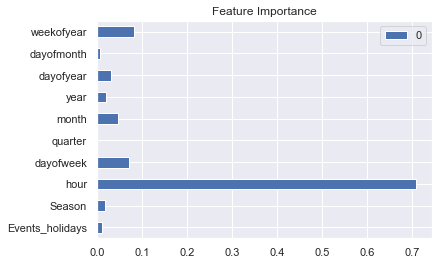

In [74]:
#Importance of each feature in the series of sales 
reg_sales_2.feature_importances_
feature_important_sales_2 = pd.DataFrame(data=reg_sales_2.feature_importances_,index=explanatory_vars)
feature_important_sales_2.plot(kind='barh', title='Feature Importance')
plt.show()

In [75]:
#Traffic
reg_traffic_2 = XGBRegressor(base_score=0.5,   
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg_traffic_2.fit(X_train_traffic_2, y_train_traffic_2,
        eval_set=[(X_train_traffic_2, y_train_traffic), (X_test_traffic_2, y_test_traffic_2)],
        verbose=100)

[0]	validation_0-rmse:20.30395	validation_1-rmse:20.05442
[100]	validation_0-rmse:11.73401	validation_1-rmse:11.62658
[200]	validation_0-rmse:8.87143	validation_1-rmse:8.85335
[300]	validation_0-rmse:7.66061	validation_1-rmse:7.73495
[400]	validation_0-rmse:7.04104	validation_1-rmse:7.20824
[500]	validation_0-rmse:6.67451	validation_1-rmse:6.88032
[600]	validation_0-rmse:6.42165	validation_1-rmse:6.66861
[700]	validation_0-rmse:6.25054	validation_1-rmse:6.52559
[800]	validation_0-rmse:6.12341	validation_1-rmse:6.43184
[900]	validation_0-rmse:6.01104	validation_1-rmse:6.34938
[999]	validation_0-rmse:5.91973	validation_1-rmse:6.28517


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [76]:
#Importance of each feature in the series of Traffic show that the season is more important than Events and holidays
reg_traffic_2.feature_importances_
feature_important_traffic_2 = pd.DataFrame(data=reg_traffic_2.feature_importances_,columns=["Importance"],index=explanatory_vars)
feature_important_traffic_2

,Importance
Events_holidays,0.082694
Season,0.032930
hour,0.241858
dayofweek,0.238887
quarter,0.000000
month,0.025344
year,0.000304
dayofyear,0.225575
dayofmonth,0.037821
weekofyear,0.114586


<center> Plotting and comparing the predictions by the models, two features and multiple features </center>

In [77]:
#Forecasting

# Two Features models
y_test_sales["Prediction"] = reg_sales.predict(X_test_sales[["Events_holidays","Season"]])
temp_y_sales = y_test_sales.set_index(X_test_sales["Date"])

y_test_traffic["Prediction"] = reg_traffic.predict(X_test_traffic[["Events_holidays","Season"]])
temp_y_traffic = y_test_traffic.set_index(X_test_traffic["Date"])


#Multiple Features Models
y_test_sales_2["Prediction"] = reg_sales_2.predict(X_test_sales_2[explanatory_vars])
temp_y_sales_2= y_test_sales_2[["Prediction", "Sales_cents"]]

y_test_traffic_2["Prediction"] = reg_traffic_2.predict(X_test_traffic_2[explanatory_vars])
temp_y_traffic_2 = y_test_traffic_2[["Prediction", "No_people"]]

In [78]:
#Metrics for the first models (two features)
actuals_sales = temp_y_sales["Sales_cents"]
predicted_sales = y_test_sales["Prediction"]

actuals_traffic = temp_y_traffic["No_people"]
predicted_traffic =temp_y_traffic["Prediction"]

print(f"XGBoost with two features for Sales Mean Absolute Error(MAE): {mean_absolute_error(actuals_sales,predicted_sales )}")
print(f"XGBoost with two features for Sales Mean Square Error(MSE): {mean_squared_error (actuals_sales, predicted_sales)}")
print(f"XGBoost with two features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_sales, predicted_sales))}")

print(f"\nXGBoost with two features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (actuals_traffic, predicted_traffic)}")
print(f"XGBoost with two features for Traffic Mean Square Error(MSE): {mean_squared_error (actuals_traffic, predicted_traffic)}")
print(f"XGBoost with two features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_traffic, predicted_traffic))}")

XGBoost with two features for Sales Mean Absolute Error(MAE): 1160.7085511944551
XGBoost with two features for Sales Mean Square Error(MSE): 1812860.7488492373
XGBoost with two features for Sales Root mean square Error(RMSE): 1346.4251738768246

XGBoost with two features for Traffic Mean Absolute Error(MAE): 10.416838146193783
XGBoost with two features for Traffic Mean Square Error(MSE): 207.84917705205999
XGBoost with two features for Traffic Root mean square Error(RMSE): 14.416975308713683


In [79]:
#Metrics for the first models (Multiple features)
actuals_sales = temp_y_sales_2["Sales_cents"]
predicted_sales = y_test_sales_2["Prediction"]

actuals_traffic = temp_y_traffic_2["No_people"]
predicted_traffic =temp_y_traffic_2["Prediction"]

print(f"XGBoost with multiple features for Sales Mean Absolute Error(MAE): {mean_absolute_error(actuals_sales,predicted_sales )}")
print(f"XGBoost with multiple features for Sales Mean Square Error(MSE): {mean_squared_error (actuals_sales, predicted_sales)}")
print(f"XGBoost with multiple features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_sales, predicted_sales))}")

print(f"\nXGBoost with multiple features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (actuals_traffic, predicted_traffic)}")
print(f"XGBoost with multiple features for Traffic Mean Square Error(MSE): {mean_squared_error (actuals_traffic, predicted_traffic)}")
print(f"XGBoost with multiple features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_traffic, predicted_traffic))}")

XGBoost with multiple features for Sales Mean Absolute Error(MAE): 333.6824854866765
XGBoost with multiple features for Sales Mean Square Error(MSE): 261834.61186865473
XGBoost with multiple features for Sales Root mean square Error(RMSE): 511.6977739531947

XGBoost with multiple features for Traffic Mean Absolute Error(MAE): 3.869919749183076
XGBoost with multiple features for Traffic Mean Square Error(MSE): 39.503280826132624
XGBoost with multiple features for Traffic Root mean square Error(RMSE): 6.285163548081515


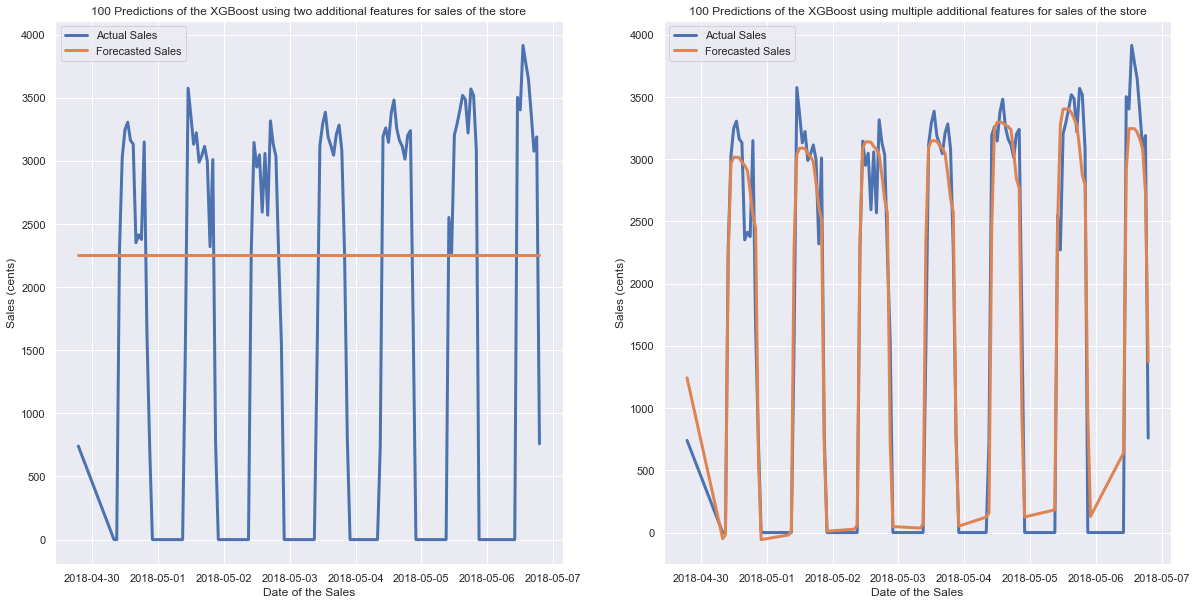

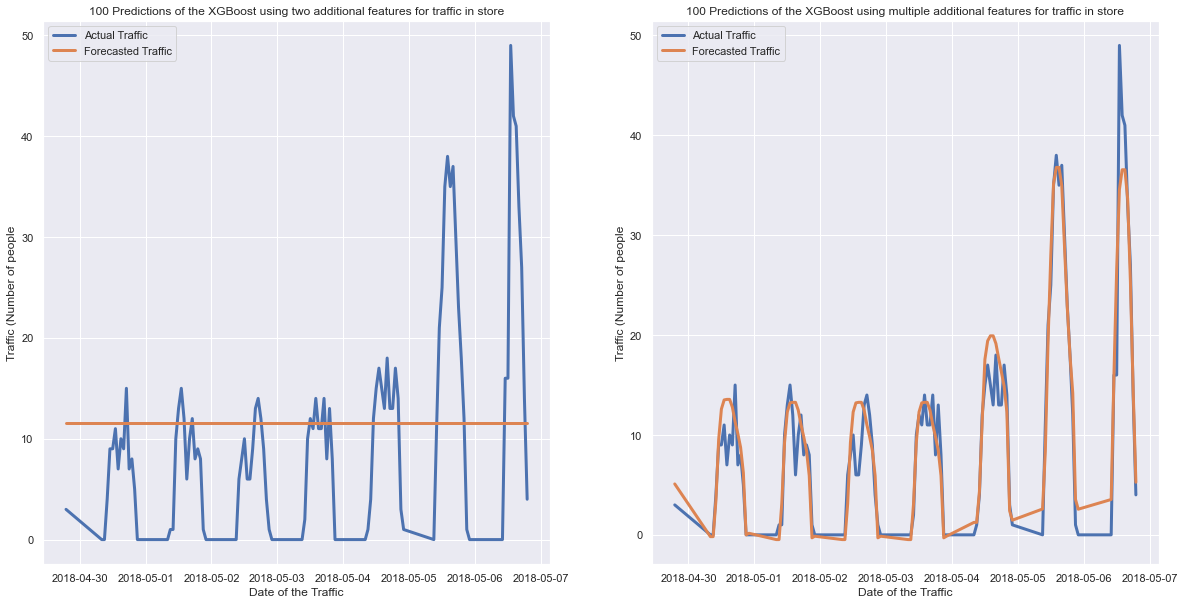

In [80]:
#Plots
fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(temp_y_sales.tail(100)["Sales_cents"], linewidth=3)
sales_axis.plot(temp_y_sales.tail(100)["Prediction"],linewidth=3)
sales_axis.set_title("100 Predictions of the XGBoost using two additional features for sales of the store")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")
sales_axis.legend(["Actual Sales","Forecasted Sales"])



sales_axis_2.plot(temp_y_sales_2.tail(100)["Sales_cents"],linewidth=3)
sales_axis_2.plot(temp_y_sales_2.tail(100)["Prediction"],linewidth=3)
sales_axis_2.set_title("100 Predictions of the XGBoost using multiple additional features for sales of the store")
sales_axis_2.set_xlabel("Date of the Sales")
sales_axis_2.set_ylabel("Sales (cents)")
sales_axis_2.legend(["Actual Sales","Forecasted Sales"])

plt.show()


fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(temp_y_traffic.tail(100)["No_people"],linewidth=3)
sales_axis.plot(temp_y_traffic.tail(100)["Prediction"],linewidth=3)
sales_axis.set_title("100 Predictions of the XGBoost using two additional features for traffic in store")
sales_axis.set_xlabel("Date of the Traffic")
sales_axis.set_ylabel("Traffic (Number of people")
sales_axis.legend(["Actual Traffic","Forecasted Traffic"])


sales_axis_2.plot(temp_y_traffic_2.tail(100)["No_people"],linewidth=3)
sales_axis_2.plot(temp_y_traffic_2.tail(100)["Prediction"],linewidth=3)
sales_axis_2.set_title("100 Predictions of the XGBoost using multiple additional features for traffic in store")
sales_axis_2.set_xlabel("Date of the Traffic")
sales_axis_2.set_ylabel("Traffic (Number of people")
sales_axis_2.legend(["Actual Traffic","Forecasted Traffic"])

plt.show()

#Removing added columns
y_test_sales.drop(columns=["Prediction"], inplace=True)
y_test_traffic.drop(columns=["Prediction"], inplace=True)
y_test_sales_2.drop(columns=["Prediction"], inplace=True)
y_test_traffic_2.drop(columns=["Prediction"], inplace=True)


As it can be seen that the multiple features is able to forecast the sales and traffic compared to the model using only two features. In addition, the metrics indicate the model with multiple features is more robust than the one with only two features

    Random Forest

a. Two Features

In [81]:
#Random forestfor the series with only two features
from sklearn.ensemble import RandomForestRegressor

#Modelling and Forecasting
model_sales_randomF = RandomForestRegressor(n_estimators=1000)
model_sales_randomF.fit(X_train_sales.set_index("Date"), y_train_sales)
predicted_sales_RF_randomF = model_sales_randomF.predict(X_test_sales.set_index("Date"))

model_traffic_randomF = RandomForestRegressor(n_estimators=1000)
model_traffic_randomF.fit(X_train_traffic.set_index("Date"), y_train_traffic)
predicted_traffic_RF_randomF= model_traffic_randomF.predict(X_test_traffic.set_index("Date"))


#Forecasting
# Two Features models
y_test_sales["Prediction"] = predicted_sales_RF_randomF
temp_y_sales = y_test_sales.set_index(X_test_sales["Date"])

y_test_traffic["Prediction"] = predicted_traffic_RF_randomF
temp_y_traffic = y_test_traffic.set_index(X_test_traffic["Date"])

#Metrics for the first models (two features)
actuals_sales_RF = temp_y_sales["Sales_cents"]
predicted_sales_RF = y_test_sales["Prediction"]

actuals_traffic_RF = temp_y_traffic["No_people"]
predicted_traffic_RF =temp_y_traffic["Prediction"]

In [82]:
#Metrics for the models with two features
print(f"Random Forest Regressor with two features for Sales Mean Absolute Error(MAE): {mean_absolute_error(actuals_sales_RF,predicted_sales_RF )}")
print(f"Random Forest Regressor with two features for Sales Mean Square Error(MSE): {mean_squared_error (actuals_sales_RF, predicted_sales_RF)}")
print(f"Random Forest Regressor with two features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_sales_RF, predicted_sales_RF))}")

print(f"\nRandom Forest Regressor with two features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (actuals_traffic_RF, predicted_traffic_RF)}")
print(f"Random Forest Regressor with two features for Traffic Mean Square Error(MSE): {mean_squared_error (actuals_traffic_RF, predicted_traffic_RF)}")
print(f"Random Forest Regressor with two features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_traffic_RF, predicted_traffic_RF))}")


Random Forest Regressor with two features for Sales Mean Absolute Error(MAE): 1160.6036447127276
Random Forest Regressor with two features for Sales Mean Square Error(MSE): 1812834.8574514203
Random Forest Regressor with two features for Sales Root mean square Error(RMSE): 1346.4155589755417

Random Forest Regressor with two features for Traffic Mean Absolute Error(MAE): 10.417271072592468
Random Forest Regressor with two features for Traffic Mean Square Error(MSE): 207.85183272705734
Random Forest Regressor with two features for Traffic Root mean square Error(RMSE): 14.417067410782865


b. Multiple Features

In [83]:
#Modelling and Forecasting
model_sales_randomF_2 = RandomForestRegressor(n_estimators=1000)
model_sales_randomF_2.fit(X_train_sales_2, y_train_sales_2)
predicted_sales_RF_randomF_2 = model_sales_randomF_2.predict(X_test_sales_2)

model_traffic_randomF_2 = RandomForestRegressor(n_estimators=1000)
model_traffic_randomF_2.fit(X_train_traffic_2, y_train_traffic_2)
predicted_traffic_RF_randomF_2= model_traffic_randomF_2.predict(X_test_traffic_2)


#Forecasting
# Two Features models
y_test_sales_2["Prediction"] = predicted_sales_RF_randomF_2
temp_y_sales_2 = y_test_sales_2.set_index(X_test_sales["Date"])

y_test_traffic_2["Prediction"] = predicted_traffic_RF_randomF_2
temp_y_traffic_2 = y_test_traffic_2.set_index(X_test_traffic["Date"])

#Metrics for the first models (two features)
actuals_sales_RF_2 = temp_y_sales_2["Sales_cents"]
predicted_sales_RF_2 = y_test_sales_2["Prediction"]

actuals_traffic_RF_2 = temp_y_traffic_2["No_people"]
predicted_traffic_RF_2 =temp_y_traffic_2["Prediction"]

In [84]:
#Metrics for the models with multiple features
print(f"Random Forest Regressor with Multiple features for Sales Mean Absolute Error(MAE): {mean_absolute_error(actuals_sales_RF_2,predicted_sales_RF_2 )}")
print(f"Random Forest Regressor with Multiple features for Sales Mean Square Error(MSE): {mean_squared_error (actuals_sales_RF_2, predicted_sales_RF_2)}")
print(f"Random Forest Regressor with Multiple features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_sales_RF_2, predicted_sales_RF_2))}")

print(f"\nRandom Forest Regressor with Multiple features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (actuals_traffic_RF_2, predicted_traffic_RF_2)}")
print(f"Random Forest Regressor with Multiple features for Traffic Mean Square Error(MSE): {mean_squared_error (actuals_traffic_RF_2, predicted_traffic_RF_2)}")
print(f"Random Forest Regressor with Multiple features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_traffic_RF_2, predicted_traffic_RF_2))}")


Random Forest Regressor with Multiple features for Sales Mean Absolute Error(MAE): 323.878817203751
Random Forest Regressor with Multiple features for Sales Mean Square Error(MSE): 269774.278286466
Random Forest Regressor with Multiple features for Sales Root mean square Error(RMSE): 519.3979960362439

Random Forest Regressor with Multiple features for Traffic Mean Absolute Error(MAE): 3.298356421858684
Random Forest Regressor with Multiple features for Traffic Mean Square Error(MSE): 29.636208469892097
Random Forest Regressor with Multiple features for Traffic Root mean square Error(RMSE): 5.443914811042886


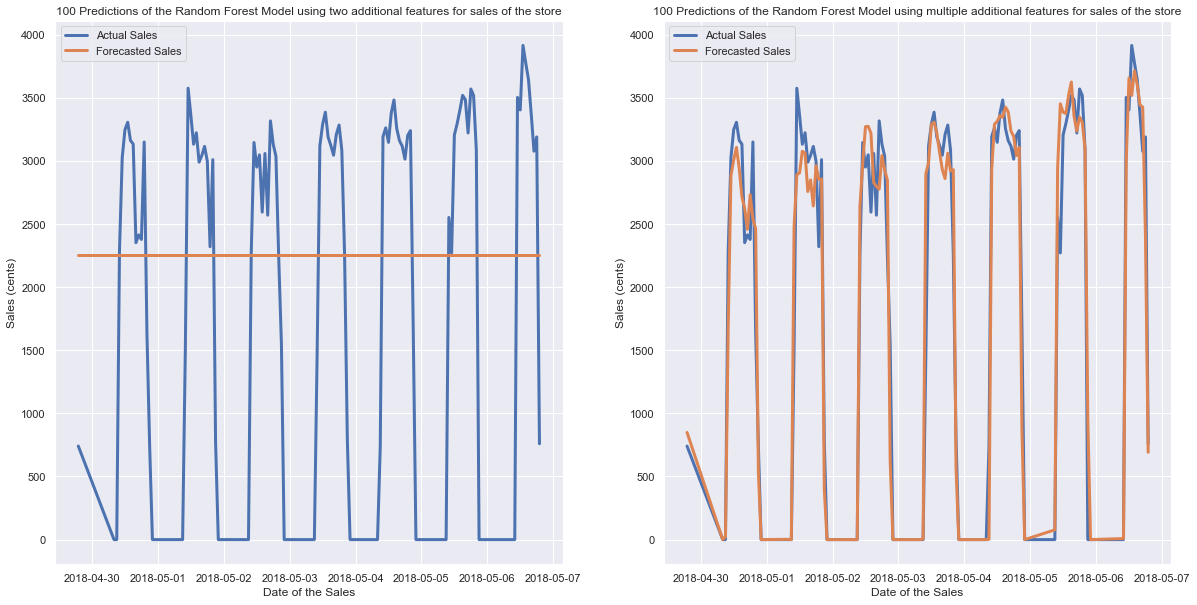

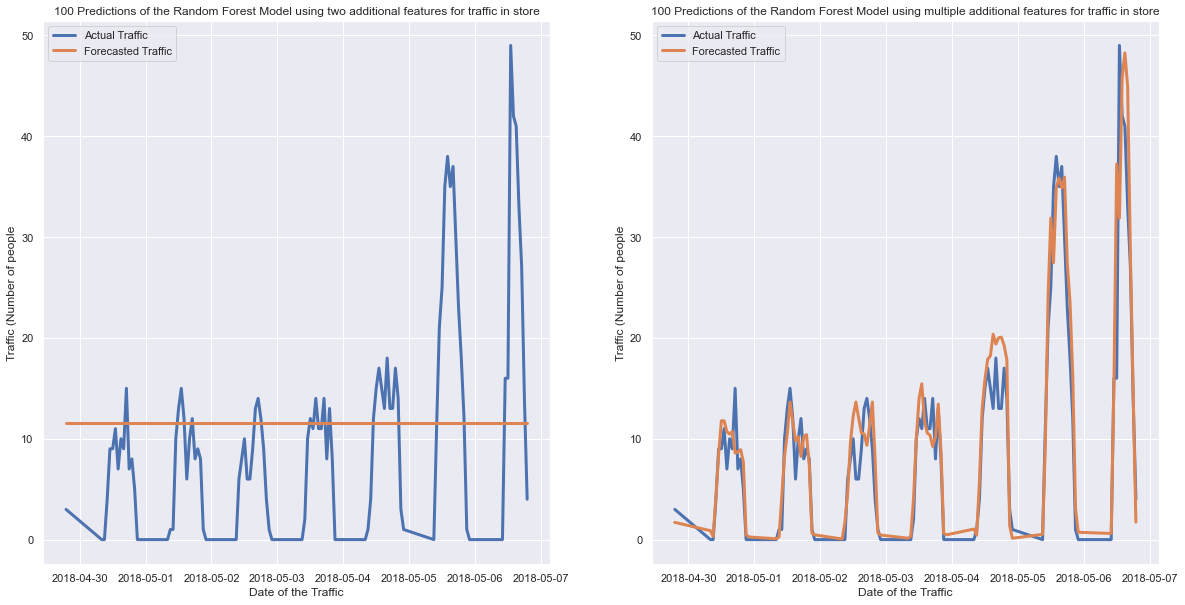

In [85]:
#Plots
fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(temp_y_sales.tail(100)["Sales_cents"], linewidth=3)
sales_axis.plot(temp_y_sales.tail(100)["Prediction"],linewidth=3)
sales_axis.set_title("100 Predictions of the Random Forest Model using two additional features for sales of the store")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")
sales_axis.legend(["Actual Sales","Forecasted Sales"])



sales_axis_2.plot(temp_y_sales_2.tail(100)["Sales_cents"],linewidth=3)
sales_axis_2.plot(temp_y_sales_2.tail(100)["Prediction"],linewidth=3)
sales_axis_2.set_title("100 Predictions of the Random Forest Model using multiple additional features for sales of the store")
sales_axis_2.set_xlabel("Date of the Sales")
sales_axis_2.set_ylabel("Sales (cents)")
sales_axis_2.legend(["Actual Sales","Forecasted Sales"])

plt.show()


fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(temp_y_traffic.tail(100)["No_people"],linewidth=3)
sales_axis.plot(temp_y_traffic.tail(100)["Prediction"],linewidth=3)
sales_axis.set_title("100 Predictions of the Random Forest Model using two additional features for traffic in store")
sales_axis.set_xlabel("Date of the Traffic")
sales_axis.set_ylabel("Traffic (Number of people")
sales_axis.legend(["Actual Traffic","Forecasted Traffic"])


sales_axis_2.plot(temp_y_traffic_2.tail(100)["No_people"],linewidth=3)
sales_axis_2.plot(temp_y_traffic_2.tail(100)["Prediction"],linewidth=3)
sales_axis_2.set_title("100 Predictions of the Random Forest Model using multiple additional features for traffic in store")
sales_axis_2.set_xlabel("Date of the Traffic")
sales_axis_2.set_ylabel("Traffic (Number of people")
sales_axis_2.legend(["Actual Traffic","Forecasted Traffic"])

plt.show()


Again, the models for the sales and traffic in store are more robust when there are multiple features included.

    Facebook Prophet

In [86]:
#Preparing series for prophet

#Trainig
prophet_train_sales = X_train_sales.copy()
prophet_train_sales["Sales_cents"] = y_train_sales
prophet_train_sales = prophet_train_sales[["Date", "Sales_cents","Events_holidays","Season"]]
prophet_train_sales.rename(columns={"Date":"ds", "Sales_cents":"y"}, inplace=True)

prophet_test_sales = X_test_sales.copy()
prophet_test_sales["Sales_cents"] = y_test_sales[["Sales_cents"]]
prophet_test_sales = prophet_test_sales[["Date", "Sales_cents","Events_holidays","Season"]]
prophet_test_sales.rename(columns={"Date":"ds", "Sales_cents":"y"}, inplace=True)

prophet_train_traffic= X_train_traffic.copy()
prophet_train_traffic["No_people"] = y_train_traffic
prophet_train_traffic= prophet_train_traffic[["Date", "No_people","Events_holidays","Season"]]
prophet_train_traffic.rename(columns={"Date":"ds", "No_people":"y"}, inplace=True)


prophet_test_traffic= X_test_traffic.copy()
prophet_test_traffic["No_people"] = y_test_traffic[["No_people"]]
prophet_test_traffic= prophet_test_traffic[["Date", "No_people","Events_holidays","Season"]]
prophet_test_traffic.rename(columns={"Date":"ds", "No_people":"y"}, inplace=True)


a. Two Features

In [87]:
from prophet import Prophet

In [88]:
# The Model using two regressors/features
prophet_sales = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
prophet_sales.add_regressor("Events_holidays")
prophet_sales.add_regressor("Season")
prophet_sales.fit(prophet_train_sales)

prophet_traffic = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
prophet_traffic.add_regressor("Events_holidays")
prophet_traffic.add_regressor("Season")
prophet_traffic.fit(prophet_train_traffic)
None


12:30:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:06 - cmdstanpy - INFO - Chain [1] done processing
12:31:06 - cmdstanpy - INFO - Chain [1] start processing
12:31:10 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
#Forecasting
prophet_forecast_sales = prophet_sales.predict(prophet_test_sales)
prophet_forecast_traffic = prophet_traffic.predict(prophet_test_traffic)

actuals_sales_prophet = prophet_test_sales[["y"]]
predicted_sales_prophet = prophet_forecast_sales[["yhat"]] #The predid gives a new completey dataframe

actuals_traffic_prophet = prophet_test_traffic[["y"]]
predicted_traffic_prophet = prophet_forecast_traffic[["yhat"]]#The predid gives a new completey dataframe


In [90]:
#Metrics
print(f"Facebook Prophet with two features for Sales Mean Absolute Error(MAE): {mean_absolute_error(actuals_sales_prophet,predicted_sales_prophet )}")
print(f"Facebook Prophet with two features for Sales Mean Square Error(MSE): {mean_squared_error (actuals_sales_prophet, predicted_sales_prophet)}")
print(f"Facebook Prophet with two features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_sales_prophet, predicted_sales_prophet))}")

print(f"\nFacebook Prophet with two features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (actuals_traffic_prophet, predicted_traffic_prophet)}")
print(f"Facebook Prophet with two features for Traffic Mean Square Error(MSE): {mean_squared_error (actuals_traffic_prophet, predicted_traffic_prophet)}")
print(f"Facebook Prophet with two features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_traffic_prophet, predicted_traffic_prophet))}")



Facebook Prophet with two features for Sales Mean Absolute Error(MAE): 416.7018691034338
Facebook Prophet with two features for Sales Mean Square Error(MSE): 376038.06467015704
Facebook Prophet with two features for Sales Root mean square Error(RMSE): 613.2194262008967

Facebook Prophet with two features for Traffic Mean Absolute Error(MAE): 6.25139407110411
Facebook Prophet with two features for Traffic Mean Square Error(MSE): 78.3081335633719
Facebook Prophet with two features for Traffic Root mean square Error(RMSE): 8.849188299690084


b. Multiple Features

In [91]:
#Preparing series for prophet using multiple features

#Sales
prophet_train_sales_2 = X_train_sales_2.copy()
prophet_train_sales_2["Sales_cents"] = y_train_sales_2
# prophet_train_sales_2 = prophet_train_sales_2[explanatory_vars]
prophet_train_sales_2.reset_index(inplace=True)#Making the Date a column for converting it to ds
prophet_train_sales_2.rename(columns={"Date":"ds", "Sales_cents":"y"}, inplace=True)

prophet_test_sales_2= X_test_sales_2.copy()
prophet_test_sales_2["Sales_cents"] = y_test_sales_2[["Sales_cents"]]
#prophet_test_sales_2 = prophet_test_sales_2[explanatory_vars]
prophet_test_sales_2.reset_index(inplace=True)#Making the Date a column for converting it to ds
prophet_test_sales_2.rename(columns={"Date":"ds", "Sales_cents":"y"}, inplace=True)

#Traffic
prophet_train_traffic_2= X_train_traffic_2.copy()
prophet_train_traffic_2["No_people"] = y_train_traffic_2
#prophet_train_traffic_2= prophet_train_traffic_2[explanatory_vars]
prophet_train_traffic_2.reset_index(inplace=True)#Making the Date a column for converting it to ds
prophet_train_traffic_2.rename(columns={"Date":"ds", "No_people":"y"}, inplace=True)

prophet_test_traffic_2= X_test_traffic_2.copy()
prophet_test_traffic_2["No_people"] = y_test_traffic_2[["No_people"]]
#prophet_test_traffic_2= prophet_test_traffic_2[explanatory_vars]#Extra variables/features
prophet_test_traffic_2.reset_index(inplace=True)#Making the Date a column for converting it to ds
prophet_test_traffic_2.rename(columns={"Date":"ds", "No_people":"y"}, inplace=True)



In [92]:
# The Model using multiple regressors/features
prophet_sales_2 = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
#Adding all the explanatory variables
for regressor in explanatory_vars:
    prophet_sales_2.add_regressor(regressor)
prophet_sales_2.fit(prophet_train_sales_2)

#Traffic
prophet_traffic_2 = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
for regressor in explanatory_vars:
    prophet_traffic_2.add_regressor(regressor)
prophet_traffic_2.fit(prophet_train_traffic_2)
None

#Forecasting
prophet_forecast_sales_2 = prophet_sales_2.predict(prophet_test_sales_2)
prophet_forecast_traffic_2 = prophet_traffic_2.predict(prophet_test_traffic_2)

actuals_sales_prophet_2 = prophet_test_sales_2[["y"]]
predicted_sales_prophet_2 = prophet_forecast_sales_2[["yhat"]] #The predid gives a new completey dataframe

# predicted_sales_plot_2 = 

actuals_traffic_prophet_2 = prophet_test_traffic_2[["y"]]
predicted_traffic_prophet_2 = prophet_forecast_traffic_2[["yhat"]]#The predid gives a new completey dataframe


12:31:23 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:43 - cmdstanpy - INFO - Chain [1] done processing


In [93]:
#Metrics
print(f"Facebook Prophet with multiple features for Sales Mean Absolute Error(MAE): {mean_absolute_error(actuals_sales_prophet_2,predicted_sales_prophet_2 )}")
print(f"Facebook Prophet with multiple features for Sales Mean Square Error(MSE): {mean_squared_error (actuals_sales_prophet_2, predicted_sales_prophet_2)}")
print(f"Facebook Prophet with multiple features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_sales_prophet_2, predicted_sales_prophet_2))}")

print(f"\nFacebook Prophet with multiple features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (actuals_traffic_prophet_2, predicted_traffic_prophet_2)}")
print(f"Facebook Prophet with multiple features for Traffic Mean Square Error(MSE): {mean_squared_error (actuals_traffic_prophet_2, predicted_traffic_prophet_2)}")
print(f"Facebook Prophet with multiple features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (actuals_traffic_prophet_2, predicted_traffic_prophet_2))}")


Facebook Prophet with multiple features for Sales Mean Absolute Error(MAE): 409.84705100092225
Facebook Prophet with multiple features for Sales Mean Square Error(MSE): 370372.96940419835
Facebook Prophet with multiple features for Sales Root mean square Error(RMSE): 608.5827547706215

Facebook Prophet with multiple features for Traffic Mean Absolute Error(MAE): 6.194045169546901
Facebook Prophet with multiple features for Traffic Mean Square Error(MSE): 76.31792354396396
Facebook Prophet with multiple features for Traffic Root mean square Error(RMSE): 8.736013023339877


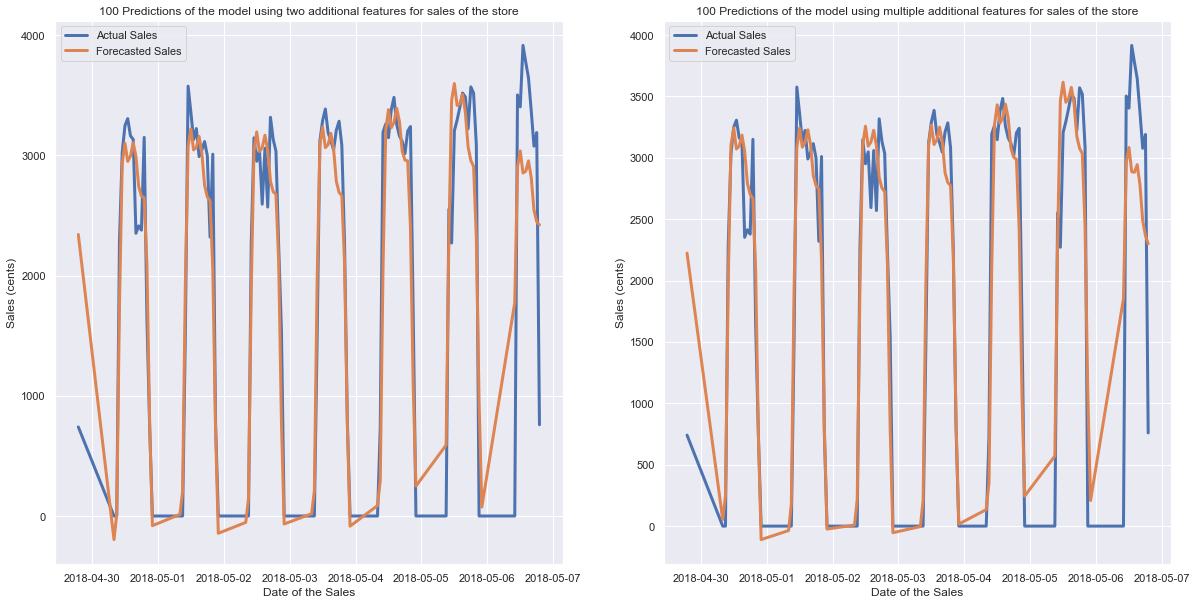

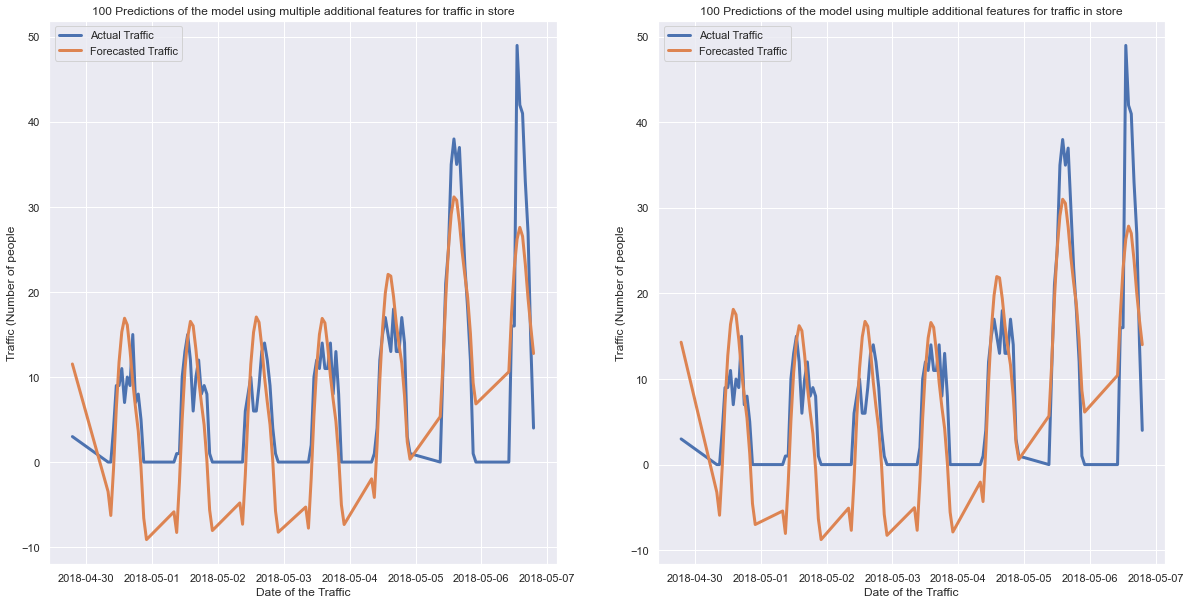

In [94]:
#Plots for actual and predicted sales & traffic 
predicted_sales_prophet_plotting = prophet_forecast_sales[["ds","yhat"]]
predicted_sales_prophet_plotting.rename(columns = {"ds":"Date","yhat":"predicted_sales"}, inplace=True)
predicted_sales_prophet_plotting.set_index("Date",inplace=True)

actuals_sales_prophet_plotting = prophet_test_sales[["ds","y"]]
actuals_sales_prophet_plotting.rename(columns = {"ds":"Date","y":"actual_sales"}, inplace=True)
actuals_sales_prophet_plotting.set_index("Date", inplace=True)

predicted_sales_prophet_plotting_2 = prophet_forecast_sales_2[["ds","yhat"]]
predicted_sales_prophet_plotting_2.rename(columns = {"ds":"Date","yhat":"predicted_sales"}, inplace=True)
predicted_sales_prophet_plotting_2.set_index("Date",inplace=True)

actuals_sales_prophet_plotting_2 = prophet_test_sales_2[["ds","y"]]
actuals_sales_prophet_plotting_2.rename(columns = {"ds":"Date","y":"actual_sales"}, inplace=True)
actuals_sales_prophet_plotting_2.set_index("Date", inplace=True)


fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(actuals_sales_prophet_plotting.tail(100)["actual_sales"], linewidth=3)
sales_axis.plot(predicted_sales_prophet_plotting.tail(100)["predicted_sales"],linewidth=3)
sales_axis.set_title("100 Predictions of the model using two additional features for sales of the store")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")
sales_axis.legend(["Actual Sales","Forecasted Sales"])


sales_axis_2.plot(actuals_sales_prophet_plotting_2.tail(100)["actual_sales"],linewidth=3)
sales_axis_2.plot(predicted_sales_prophet_plotting_2.tail(100)["predicted_sales"],linewidth=3)
sales_axis_2.set_title("100 Predictions of the model using multiple additional features for sales of the store")
sales_axis_2.set_xlabel("Date of the Sales")
sales_axis_2.set_ylabel("Sales (cents)")
sales_axis_2.legend(["Actual Sales","Forecasted Sales"])
plt.show()


predicted_traffic_prophet_plotting = prophet_forecast_traffic[["ds","yhat"]]
predicted_traffic_prophet_plotting.rename(columns = {"ds":"Date","yhat":"predicted_traffic"}, inplace=True)
predicted_traffic_prophet_plotting.set_index("Date",inplace=True)

actuals_traffic_prophet_plotting = prophet_test_traffic[["ds","y"]]
actuals_traffic_prophet_plotting.rename(columns = {"ds":"Date","y":"actual_traffic"}, inplace=True)
actuals_traffic_prophet_plotting.set_index("Date", inplace=True)


predicted_traffic_prophet_plotting_2 = prophet_forecast_traffic_2[["ds","yhat"]]
predicted_traffic_prophet_plotting_2.rename(columns = {"ds":"Date","yhat":"predicted_traffic"}, inplace=True)
predicted_traffic_prophet_plotting_2.set_index("Date",inplace=True)

actuals_traffic_prophet_plotting_2 = prophet_test_traffic_2[["ds","y"]]
actuals_traffic_prophet_plotting_2.rename(columns = {"ds":"Date","y":"actual_traffic"}, inplace=True)
actuals_traffic_prophet_plotting_2.set_index("Date", inplace=True)

fig, (traffic_axis,traffic_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
traffic_axis.plot(actuals_traffic_prophet_plotting.tail(100)["actual_traffic"],linewidth=3)
traffic_axis.plot(predicted_traffic_prophet_plotting.tail(100)["predicted_traffic"],linewidth=3)
traffic_axis.set_title("100 Predictions of the model using multiple additional features for traffic in store")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic (Number of people")
traffic_axis.legend(["Actual Traffic","Forecasted Traffic"])

traffic_axis_2.plot(actuals_traffic_prophet_plotting_2.tail(100)["actual_traffic"],linewidth=3)
traffic_axis_2.plot(predicted_traffic_prophet_plotting_2.tail(100)["predicted_traffic"],linewidth=3)
traffic_axis_2.set_title("100 Predictions of the model using multiple additional features for traffic in store")
traffic_axis_2.set_xlabel("Date of the Traffic")
traffic_axis_2.set_ylabel("Traffic (Number of people")
traffic_axis_2.legend(["Actual Traffic","Forecasted Traffic"])
plt.show()

The traffic plots may seem that the models forecasted similar values though they are different, below is a plot of 3 hours to illustrates that the models forecasted closer values for the sales and traffic. For sales the difference can spotted easily though they also look the same. On the otherhand, the traffic is not quite clear.

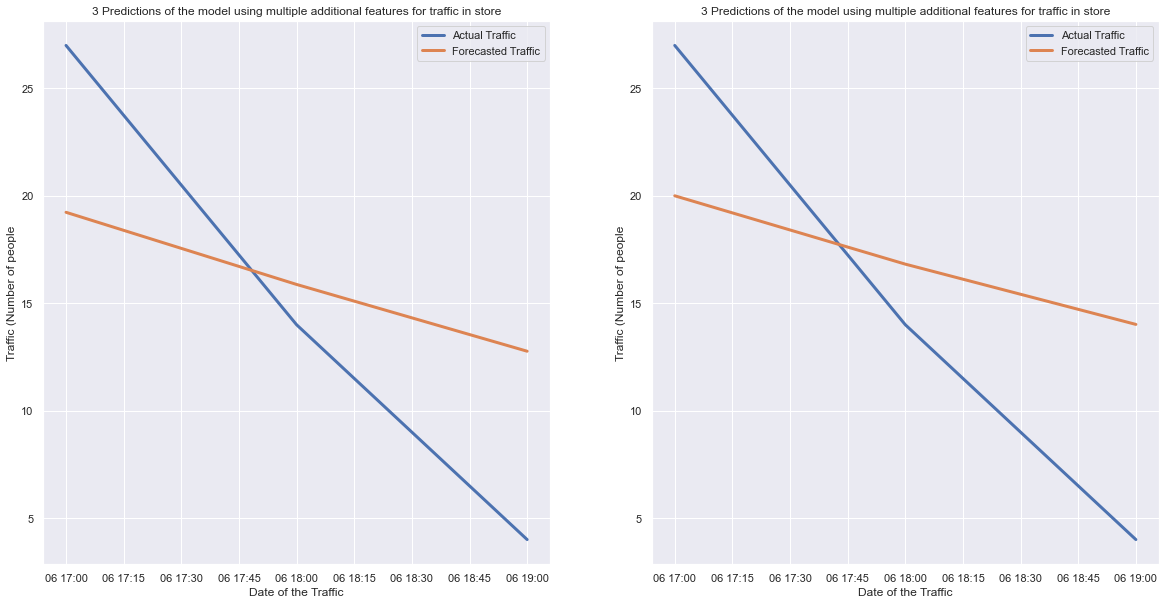

In [95]:
# Plots for illustarting the difference
fig, (traffic_axis,traffic_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
traffic_axis.plot(actuals_traffic_prophet_plotting.tail(3)["actual_traffic"],linewidth=3)
traffic_axis.plot(predicted_traffic_prophet_plotting.tail(3)["predicted_traffic"],linewidth=3)
traffic_axis.set_title("3 Predictions of the model using multiple additional features for traffic in store")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic (Number of people")
traffic_axis.legend(["Actual Traffic","Forecasted Traffic"])

traffic_axis_2.plot(actuals_traffic_prophet_plotting_2.tail(3)["actual_traffic"],linewidth=3)
traffic_axis_2.plot(predicted_traffic_prophet_plotting_2.tail(3)["predicted_traffic"],linewidth=3)
traffic_axis_2.set_title("3 Predictions of the model using multiple additional features for traffic in store")
traffic_axis_2.set_xlabel("Date of the Traffic")
traffic_axis_2.set_ylabel("Traffic (Number of people")
traffic_axis_2.legend(["Actual Traffic","Forecasted Traffic"])
plt.show()


    - SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors)
    


The ARIMA model is fantastic, but incorporating seasonality and exogenous variables into the model can make it highly effective. We must use a different model because the ARIMA model assumes that the time series is stationary.

In [96]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [97]:
#Preparing the datasets for the SARIMAX model
X_train_sales_SARIMA = X_train_sales.set_index("Date")
X_train_traffic_SARIMA = X_train_traffic.set_index("Date")


y_train_sales_sarima = y_train_sales.set_index(X_train_sales_SARIMA.index)
y_train_traffic_sarima = y_train_traffic.set_index(X_train_traffic_SARIMA.index)

X_train_sales_SARIMA["Actual"]= y_train_sales["Sales_cents"].values
X_train_traffic_SARIMA["Actual"]= y_train_traffic["No_people"].values

X_test_sales_SARIMA = X_test_sales.set_index("Date")
X_test_traffic_SARIMA = X_test_traffic.set_index("Date")


y_test_sales_sarima = y_test_sales.set_index(X_test_sales_SARIMA.index)
y_test_traffic_sarima = y_test_traffic.set_index(X_test_traffic_SARIMA.index)

X_test_sales_SARIMA["Actual"]= y_test_sales["Sales_cents"].values
X_test_traffic_SARIMA["Actual"]= y_test_traffic["No_people"].values

In [98]:
#Finding the optimal parameters for the model
#apprx 12 to 15 mins to run commented it out as it gave me the order already and it does change
from pmdarima import auto_arima
#auto_arima(df_sales_temp["Sales_cents"], exogenous = df_sales_temp[["Events_holidays","Season"]],trace=True, m=1, seasonal=True).summary()

In [99]:
#Finding the obtimal parameters for the model
#pprx 15-18 mins to run, #apprx 12 to 15 mins to run commented it out as it gave me the order already and it does change

#auto_arima(df_traffic_temp["No_people"], exogenous = df_traffic_temp[["Events_holidays","Season"]],trace=True, m=1, seasonal=True).summary()

In [100]:
# Training the model and testing (sales)with two features)
sarimax_sales_model = SARIMAX(X_train_sales_SARIMA["Actual"],exog= X_train_sales_SARIMA[["Events_holidays","Season"]],order=(2, 1, 2), seasonal_order=(0,0,0,0))#Order determined by the auto arima
sarimax_sales_model = sarimax_sales_model.fit()

prediction_sarimax_sales= pd.DataFrame(sarimax_sales_model.predict(start = len(X_train_sales_SARIMA), end = (len(X_train_sales_SARIMA)+len(X_test_sales)-1),exog= X_test_sales_SARIMA[["Events_holidays","Season"]]).rename("Predicted_sales"))
prediction_sarimax_sales["actual_sales"]=y_test_sales["Sales_cents"].values #final daftaframe for plotting
prediction_sarimax_sales.set_index(y_test_sales_sarima.index,inplace=True)

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31491D+00    |proj g|=  1.55464D-01

At iterate    5    f=  8.26826D+00    |proj g|=  3.27695D-02

At iterate   10    f=  8.19464D+00    |proj g|=  2.48704D-02

At iterate   15    f=  8.19063D+00    |proj g|=  9.24424D-04

At iterate   20    f=  8.19001D+00    |proj g|=  1.15546D-02

At iterate   25    f=  8.18959D+00    |proj g|=  2.50880D-04

At iterate   30    f=  8.18940D+00    |proj g|=  2.69061D-03

At iterate   35    f=  8.17816D+00    |proj g|=  1.51406D-02

At iterate   40    f=  8.17113D+00    |proj g|=  1.85292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [101]:
# Training the model and testing  traffic with two features
sarimax_traffic_model = SARIMAX(X_train_traffic_SARIMA["Actual"],exog= X_train_traffic_SARIMA[["Events_holidays","Season"]],order=(5, 1, 3), seasonal_order=(0,0,0,0))#Order determined by the auto arima
sarimax_traffic_model = sarimax_traffic_model.fit()

prediction_sarimax_traffic= pd.DataFrame(sarimax_traffic_model.predict(start = len(X_train_traffic_SARIMA), end = (len(X_train_traffic_SARIMA)+len(X_test_traffic)-1),exog= X_test_traffic_SARIMA[["Events_holidays","Season"]]).rename("Predicted_traffic"))
prediction_sarimax_traffic["actual_traffic"]=y_test_traffic["No_people"].values #final daftaframe for plotting
prediction_sarimax_traffic.set_index(y_test_traffic_sarima.index,inplace=True)

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54217D+00    |proj g|=  4.13465D-01

At iterate    5    f=  3.28983D+00    |proj g|=  6.29506D-02

At iterate   10    f=  3.27973D+00    |proj g|=  2.44176D-02

At iterate   15    f=  3.25956D+00    |proj g|=  4.94182D-02

At iterate   20    f=  3.25483D+00    |proj g|=  1.81913D-02

At iterate   25    f=  3.25390D+00    |proj g|=  5.02987D-04

At iterate   30    f=  3.25388D+00    |proj g|=  1.66049D-03

At iterate   35    f=  3.25330D+00    |proj g|=  1.03248D-02

At iterate   40    f=  3.25290D+00    |proj g|=  4.64257D-04

At iterate   45    f=  3.25290D+00    |proj g|=  4.02767D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [102]:
#Metrics
#Metrics
sarima_sales_actuals = prediction_sarimax_sales[["actual_sales"]]
sarima_sales_predicted =  prediction_sarimax_sales[["Predicted_sales"]]

sarima_traffic_actuals = prediction_sarimax_traffic[["actual_traffic"]]
sarima_traffic_predicted =  prediction_sarimax_traffic[["Predicted_traffic"]]

print(f"SARIMAX with two features for Sales Mean Absolute Error(MAE): {mean_absolute_error(sarima_sales_actuals,sarima_sales_predicted )}")
print(f"SARIMAX with two features for Sales Mean Square Error(MSE): {mean_squared_error (sarima_sales_actuals, sarima_sales_predicted)}")
print(f"SARIMAX with two features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (sarima_sales_actuals, sarima_sales_predicted))}")

print(f"\nSARIMAX with two features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (sarima_traffic_actuals , sarima_traffic_predicted)}")
print(f"SARIMAX with two features for Traffic Mean Square Error(MSE): {mean_squared_error (sarima_traffic_actuals , sarima_traffic_predicted)}")
print(f"SARIMAX with two features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (sarima_traffic_actuals , sarima_traffic_predicted))}")



SARIMAX with two features for Sales Mean Absolute Error(MAE): 1146.6093189630042
SARIMAX with two features for Sales Mean Square Error(MSE): 1820149.7854843987
SARIMAX with two features for Sales Root mean square Error(RMSE): 1349.1292693750288

SARIMAX with two features for Traffic Mean Absolute Error(MAE): 14.36572666289714
SARIMAX with two features for Traffic Mean Square Error(MSE): 284.4899680889189
SARIMAX with two features for Traffic Root mean square Error(RMSE): 16.866830410273263


b. Multiple features

In [103]:
#Preparing the datasets for the SARIMAX model
X_train_sales_SARIMA_2 = X_train_sales_2
X_train_traffic_SARIMA_2 = X_train_traffic_2


y_train_sales_sarima_2 = y_train_sales_2.set_index(X_train_sales_SARIMA_2.index)
y_train_traffic_sarima_2 = y_train_traffic_2.set_index(X_train_traffic_SARIMA_2.index)

X_train_sales_SARIMA_2["Actual"]= y_train_sales_2["Sales_cents"].values
X_train_traffic_SARIMA_2["Actual"]= y_train_traffic_2["No_people"].values

X_test_sales_SARIMA_2 = X_test_sales_2
X_test_traffic_SARIMA_2 = X_test_traffic_2


y_test_sales_sarima_2 = y_test_sales_2.set_index(X_test_sales_SARIMA_2.index)
y_test_traffic_sarima_2 = y_test_traffic_2.set_index(X_test_traffic_SARIMA_2.index)

X_test_sales_SARIMA_2["Actual"]= y_test_sales_2["Sales_cents"].values
X_test_traffic_SARIMA_2["Actual"]= y_test_traffic_2["No_people"].values

In [104]:
#Finding the obtimal parameters for the model (Sales)

#auto_arima(df_sales_temp_2["Sales_cents"], exogenous = df_sales_temp_2[explanatory_vars],trace=True, m=1, seasonal=True).summary()

In [105]:
#Finding the optimal parameters for the model (Traffic)
#auto_arima(df_traffic_temp_2["No_people"], exogenous = df_traffic_temp_2[explanatory_vars],trace=True, m=1, seasonal=True).summary()

In [106]:
# Training the model and testing (sales)with multiple features)
sarimax_sales_model_2 = SARIMAX(X_train_sales_SARIMA_2["Actual"],exog= X_train_sales_SARIMA_2[explanatory_vars],order=(2, 1, 2), seasonal_order=(0,0,0,0))#Order determined by the auto arima
sarimax_sales_model_2 = sarimax_sales_model_2.fit()

prediction_sarimax_sales_2= pd.DataFrame(sarimax_sales_model_2.predict(start = len(X_train_sales_SARIMA_2), end = (len(X_train_sales_SARIMA_2)+len(X_test_sales_2)-1),exog= X_test_sales_SARIMA_2[explanatory_vars]).rename("Predicted_sales"))
prediction_sarimax_sales_2["actual_sales"]=y_test_sales_2["Sales_cents"].values #final dataframe for plotting
prediction_sarimax_sales_2.set_index(y_test_sales_sarima_2.index,inplace=True)

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.65518D+02    |proj g|=  1.71307D+04


 This problem is unconstrained.



At iterate    5    f=  8.34012D+00    |proj g|=  1.13080D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15      6     19      1     0     0   1.141D+00   8.340D+00
  F =   8.3401209845168367     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [107]:
# Training the model and testing  traffic with multiple features
sarimax_traffic_model_2 = SARIMAX(X_train_traffic_SARIMA_2["Actual"],exog= X_train_traffic_SARIMA_2[explanatory_vars],order=(2, 1, 2), seasonal_order=(0,0,0,0))#Order determined by the auto arima
sarimax_traffic_model_2 = sarimax_traffic_model_2.fit()

prediction_sarimax_traffic_2= pd.DataFrame(sarimax_traffic_model_2.predict(start = len(X_train_traffic_SARIMA_2), end = (len(X_train_traffic_SARIMA_2)+len(X_test_traffic_2)-1),exog= X_test_traffic_SARIMA_2[explanatory_vars]).rename("Predicted_traffic"))
prediction_sarimax_traffic_2["actual_traffic"]=y_test_traffic_2["No_people"].values #final dataframe for plotting
prediction_sarimax_traffic_2.set_index(y_test_traffic_sarima_2.index,inplace=True)

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44460D+00    |proj g|=  2.69532D-01


 This problem is unconstrained.



At iterate    5    f=  3.35751D+00    |proj g|=  5.00490D-02

At iterate   10    f=  3.28967D+00    |proj g|=  6.64125D-02

At iterate   15    f=  3.26728D+00    |proj g|=  7.98199D-03

At iterate   20    f=  3.26333D+00    |proj g|=  3.16346D-03

At iterate   25    f=  3.26292D+00    |proj g|=  3.45284D-04

At iterate   30    f=  3.26288D+00    |proj g|=  2.49215D-03

At iterate   35    f=  3.26256D+00    |proj g|=  6.08278D-03

At iterate   40    f=  3.26236D+00    |proj g|=  4.49265D-04

At iterate   45    f=  3.26236D+00    |proj g|=  2.97303D-05

At iterate   50    f=  3.26236D+00    |proj g|=  1.23491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/melvinshongwe/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [108]:
#Metrics
sarima_sales_actuals_2 = prediction_sarimax_sales_2[["actual_sales"]]
sarima_sales_predicted_2 =  prediction_sarimax_sales_2[["Predicted_sales"]]

sarima_traffic_actuals_2 = prediction_sarimax_traffic_2[["actual_traffic"]]
sarima_traffic_predicted_2 =  prediction_sarimax_traffic_2[["Predicted_traffic"]]
print(f"SARIMAX with multiple features for Sales Mean Absolute Error(MAE): {mean_absolute_error(sarima_sales_actuals_2,sarima_sales_predicted_2 )}")
print(f"SARIMAX with multiple features for Sales Mean Square Error(MSE): {mean_squared_error (sarima_sales_actuals_2, sarima_sales_predicted_2)}")
print(f"SARIMAX with multiple features for Sales Root mean square Error(RMSE): {np.sqrt(mean_squared_error (sarima_sales_actuals_2, sarima_sales_predicted_2))}")

print(f"\nSARIMAX with multiple features for Traffic Mean Absolute Error(MAE): {mean_absolute_error (sarima_traffic_actuals_2 , sarima_traffic_predicted_2)}")
print(f"SARIMAX with multiple features for Traffic Mean Square Error(MSE): {mean_squared_error (sarima_traffic_actuals_2 , sarima_traffic_predicted_2)}")
print(f"SARIMAX with multiple features for Traffic Root mean square Error(RMSE): {np.sqrt(mean_squared_error (sarima_traffic_actuals_2 , sarima_traffic_predicted_2))}")


SARIMAX with multiple features for Sales Mean Absolute Error(MAE): 45869.39516889745
SARIMAX with multiple features for Sales Mean Square Error(MSE): 2784417038.6584544
SARIMAX with multiple features for Sales Root mean square Error(RMSE): 52767.57563749214

SARIMAX with multiple features for Traffic Mean Absolute Error(MAE): 208.79495567982087
SARIMAX with multiple features for Traffic Mean Square Error(MSE): 56968.249375950465
SARIMAX with multiple features for Traffic Root mean square Error(RMSE): 238.68022409900337


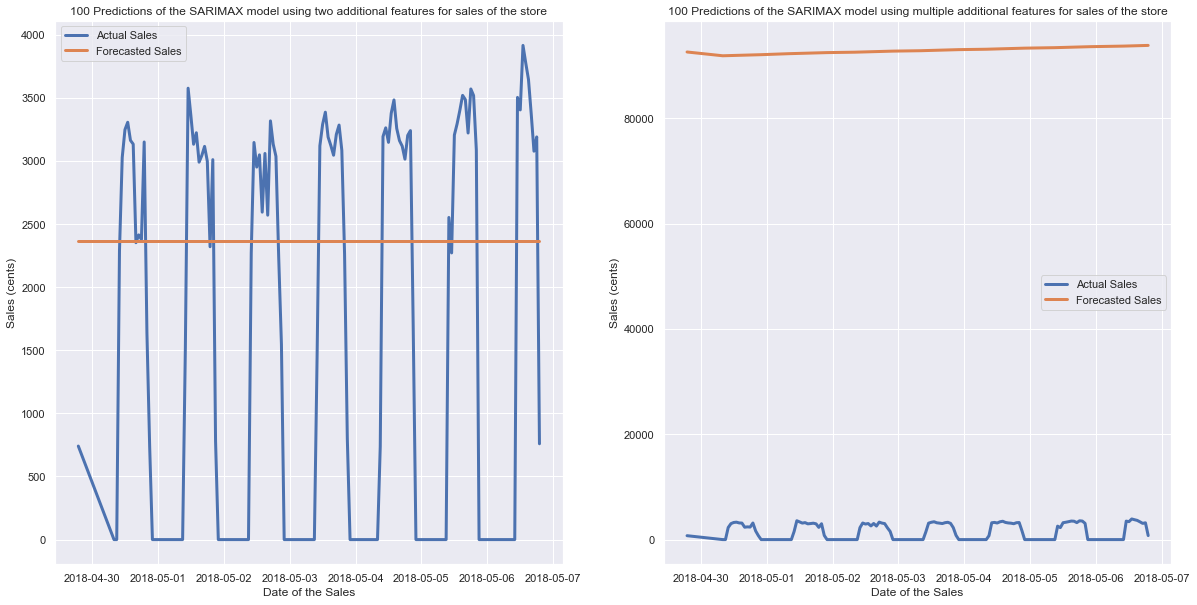

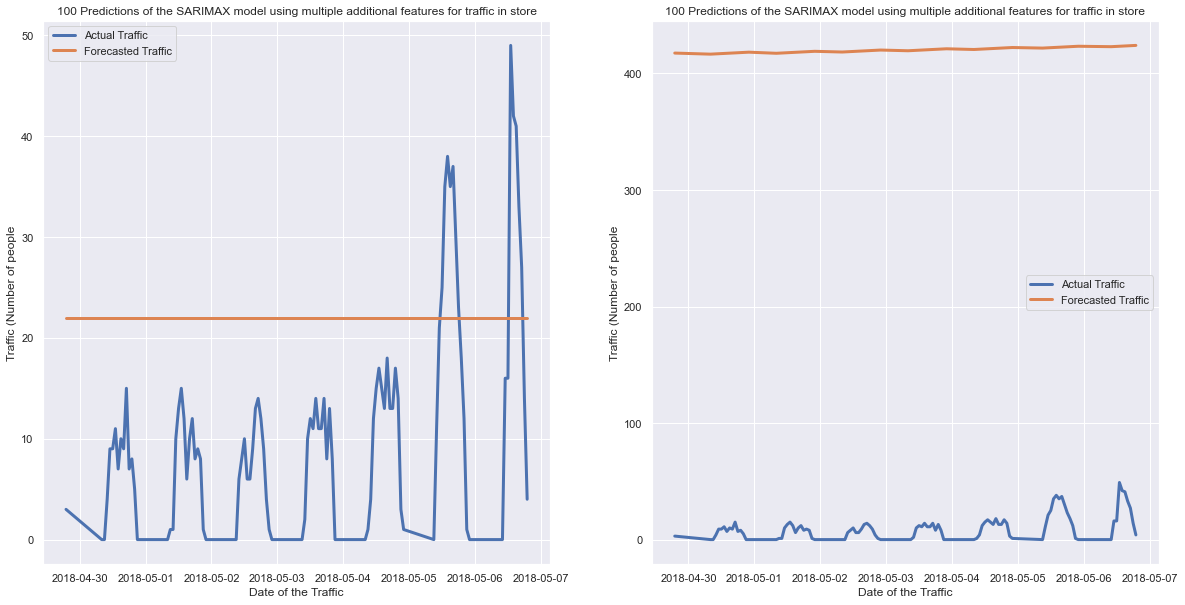

In [109]:
#Plots
fig, (sales_axis,sales_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
sales_axis.plot(prediction_sarimax_sales.tail(100)["actual_sales"], linewidth=3)
sales_axis.plot(prediction_sarimax_sales.tail(100)["Predicted_sales"],linewidth=3)
sales_axis.set_title("100 Predictions of the SARIMAX model using two additional features for sales of the store")
sales_axis.set_xlabel("Date of the Sales")
sales_axis.set_ylabel("Sales (cents)")
sales_axis.legend(["Actual Sales","Forecasted Sales"])


sales_axis_2.plot(prediction_sarimax_sales_2.tail(100)["actual_sales"], linewidth=3)
sales_axis_2.plot(prediction_sarimax_sales_2.tail(100)["Predicted_sales"],linewidth=3)
sales_axis_2.set_title("100 Predictions of the SARIMAX model using multiple additional features for sales of the store")
sales_axis_2.set_xlabel("Date of the Sales")
sales_axis_2.set_ylabel("Sales (cents)")
sales_axis_2.legend(["Actual Sales","Forecasted Sales"])
plt.show()

fig, (traffic_axis,traffic_axis_2) = plt.subplots(ncols=2,nrows=1, figsize=(20,10))
traffic_axis.plot(prediction_sarimax_traffic.tail(100)["actual_traffic"], linewidth=3)
traffic_axis.plot(prediction_sarimax_traffic.tail(100)["Predicted_traffic"],linewidth=3)
traffic_axis.set_title("100 Predictions of the SARIMAX model using multiple additional features for traffic in store")
traffic_axis.set_xlabel("Date of the Traffic")
traffic_axis.set_ylabel("Traffic (Number of people")
traffic_axis.legend(["Actual Traffic","Forecasted Traffic"])


traffic_axis_2.plot(prediction_sarimax_traffic_2.tail(100)["actual_traffic"], linewidth=3)
traffic_axis_2.plot(prediction_sarimax_traffic_2.tail(100)["Predicted_traffic"],linewidth=3)
traffic_axis_2.set_title("100 Predictions of the SARIMAX model using multiple additional features for traffic in store")
traffic_axis_2.set_xlabel("Date of the Traffic")
traffic_axis_2.set_ylabel("Traffic (Number of people")
traffic_axis_2.legend(["Actual Traffic","Forecasted Traffic"])
plt.show()

<center>Model Selection</center>

Choosing the right error metrics for your Machine Learning project is critical. A bad error metric will not only skew your model's optimization (loss function), but it will also skew your judgment of models. A study stated that MSE and RMSE are sufficient for a evaluating a model.

link: https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7#:~:text=Currently%2C%20the%20most%20popular%20metrics,are%20MAE%2C%20RMSE%20and%20AIC.&text=To%20briefly%20summarize%2C%20both%20MAE,impact%20of%20the%20large%20errors.

    - Sales models metrics

- **Linear regression**
    - Two features
        - $MSE=1804533.01606$
        - $RMSE=1343.3290$
    - Multiple Features
        - $MSE=1778306.982$
        - $RMSE=1333.5317$

- **XGboost**
    - Two features
        - $MSE=1812860.748$
        - $RMSE=1346.4251$
    - Multiple Features
        - $MSE=261834.6118$
        - $RMSE = 511.69777$

- **Random Forest**
    - Two features
        - $MSE=1812875.5687$
        - $RMSE=1346.4306$
    - Multiple Features
        - $MSE=269802.905179$
        - $RMSE=519.4255$

- **FBProphet**
    - Two features
        - $MSE=376038.0646$
        - $RMSE=613.2194$
    - Multiple Features
        - $MSE = 370372.969$
        - $RMSE=608.582$
- **SARIMA**
    - Two features
        - $MSE = 1820149.78$
        - $RMSE = 1349.1292$
    - Multiple Features
        - $MSE=2784417038.658$
        - $RMSE=52767.57563$


    - Traffic models metrics

- **Linear regression**
    - Two features
        - $MSE= 211.678106$
        - $RMSE=14.549161$
    - Multiple Features
        - $MSE= 174.4038$
        - $RMSE= 13.20620$

- **XGboost**
    - Two features
        - $MSE= 207.849177$
        - $RMSE= 14.416975$
    - Multiple Features
        - $MSE= 39.50328$
        - $RMSE= 6.285163$

- **Random Forest**
    - Two features
        - $MSE=207.83880$
        - $RMSE=14.41661$
    - Multiple Features
        - $MSE= 29.831977$
        - $RMSE=5.4618657$

- **FBProphet**
    - Two features
        - $MSE= 78.3081$
        - $RMSE=8.84918$
    - Multiple Features
        - $MSE= 76.31792$
        - $RMSE= 8.7360130$
        
- **SARIMAX**
    - Two features
        - $MSE= 284.4899$
        - $RMSE= 16.8668$
    - Multiple Features
        - $MSE= 56968.249$
        - $RMSE= 238.6802$


    By looking at these metrics I can identity models that will be able to forecast the sales and the traffic of the store for the next month.

- Random Forest(1), XGBoost(2) and  FBProphet(3) are the top three models that are able to forecast the sales and traffic of the store.

    - The models with more features seem to have good performance than the models with only two features except for the SARIMAX model as it is an inverse in both cases (Sales and Traffic).
    - The FB Prophet may seem to be the least from the top 3, but it is more volatile and it is not influenced by most of the features as the metrics of the model with multiple features slightly differs from the model with only two features which suggest that the features do not contribute much to the model.



    The forecast will be implemented using the model (Random Forest) with multiple features which is the optimal model according to the metrics.

## <CENTER> 4. Forecasting using the Best performing models</CENTER>

<center>Generating Dates for Forecasting</center>

In [110]:
def generate_month_dates(df_name):
    #Period (Hours per month (31 days) apx  720) I set it to be large intentinally but according to this problem a month is approximately 460, and  2 days will be removed
    times = pd.Series(pd.date_range('2018-05-07', periods=780, freq='60min')) 
    times_df = pd.DataFrame(data=times, columns=["Date"]) 

    times_df["weekday"] = times_df.Date.dt.day_name()

    #Will Check for Saturday, Sunday and Monday for both dataset
    sales_saturdays_times = times_df[times_df["weekday"]=="Saturday"]
    sales_sundays_times = times_df[times_df["weekday"]=="Sunday"]
    sales_monday_times = times_df[times_df["weekday"]=="Monday"]

    #Removing the times where the store was not operating
    times_df= times_df[((times_df["Date"].dt.hour<=22)&(times_df["Date"].dt.hour>=8))] #Weekdays
    f_sales_temp= times_df.drop(times_df[(times_df["Date"].dt.hour==8) & (times_df["weekday"]=="Saturday")].index)#Saturday
    times_df= times_df.drop(times_df[(times_df["Date"].dt.hour==8) & (times_df["weekday"]=="Sunday")].index)#Sundays
    times_df= times_df.drop(times_df[(times_df["Date"].dt.hour==9) & (times_df["weekday"]=="Sunday")].index)#Sundays
    f_sales_temp= times_df.drop(times_df[(times_df["Date"].dt.hour>=20) & (times_df["weekday"]=="Sunday")].index)#Sundays
    times_df.drop(columns=["weekday"], inplace=True) #Removing the added column

    #If the date lies in the weekend of backfriday for future prediction by the store
    holidays = list(USFederalHolidayCalendar().holidays(start=times_df.Date.min().date(), end=times_df.Date.max().date()).date)

    for date in black_fridays:
        if date not in holidays:
            holidays.append(date)
    for date in business_saturdays:
        if date not in holidays:
            holidays.append(date)
    for date in sofa_sundays:
        if date not in holidays:
            holidays.append(date)
    for date in cyber_mondays:
        if date not in holidays:
            holidays.append(date)

    times_df["date_only"]= times_df["Date"].dt.date
    times_df['Events_holidays'] = times_df.date_only.isin(holidays).astype(int)

    times_df.drop(columns=["date_only"], inplace=True)
    times_final_df = derive_features_from_timestamp(times_df.set_index("Date"))

    season_dict = {'January': 'Winter',
               'February': 'Winter',
               'March': 'Spring', 
               'April': 'Spring',
               'May': 'Spring',
               'June': 'Summer',
               'July': 'Summer',
               'August': 'Summer',
               'September': 'Fall',
               'October': 'Fall',
               'November': 'Fall',
               'December': 'Winter'}

    times_final_df["month"]=times_final_df.index.month_name()

    times_final_df["Season"]=times_final_df["month"].apply(lambda x : season_dict[x])

    times_final_df.drop(columns=["month"],inplace=True)
    times_final_df["month"]=times_final_df.index.month


    if df_name=="Sales":
        times_final_df.replace("Winter", 2, inplace=True)
        times_final_df.replace(["Spring","Summer","Fall"], 1, inplace=True)

    if df_name=="Traffic":

        times_final_df.replace("Winter", 3, inplace=True)
        times_final_df.replace("Summer", 2, inplace=True)
        times_final_df.replace(["Spring","Fall"], 1, inplace=True)

    return times_final_df[explanatory_vars]


In [111]:
#Genarated Dates for forecasting Overview
sales_forecasting_df = generate_month_dates("Sales")
xgboost_sales = generate_month_dates("Sales")
traffic_forecasting_df=generate_month_dates("Traffic")
xgboost_traffic=generate_month_dates("Traffic")
generate_month_dates("Sales")


,Events_holidays,Season,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,
2018-05-07 08:00:00,0,1,8,0,2,5,2018,127,7,19
2018-05-07 09:00:00,0,1,9,0,2,5,2018,127,7,19
2018-05-07 10:00:00,0,1,10,0,2,5,2018,127,7,19
2018-05-07 11:00:00,0,1,11,0,2,5,2018,127,7,19
2018-05-07 12:00:00,0,1,12,0,2,5,2018,127,7,19
...,...,...,...,...,...,...,...,...,...,...
2018-06-07 22:00:00,0,1,22,3,2,6,2018,158,7,23
2018-06-08 08:00:00,0,1,8,4,2,6,2018,159,8,23
2018-06-08 09:00:00,0,1,9,4,2,6,2018,159,8,23


    - Random Forest and XGBoost (Multiple Features)

<center>Sales</center>

In [112]:
#The predicted sales using random forest (overview)
#Forecasting sales
next_month_sales_forecast= model_sales_randomF_2.predict(sales_forecasting_df)
forecasted_sales = pd.DataFrame(next_month_sales_forecast).rename(columns={0:"Predicted_sales_RF"})
xgb_forecasted_sales = pd.DataFrame(reg_sales_2.predict(xgboost_sales)).rename(columns={0:"Predicted_sales_XGB"}).astype(float)#Avoiding float32

sales_forecasting_df["Predicted_sales_RF"]=forecasted_sales["Predicted_sales_RF"].values
sales_forecasting_df["Predicted_sales_XGB"]=xgb_forecasted_sales["Predicted_sales_XGB"].values

final_sales_forecast_df = sales_forecasting_df[["Predicted_sales_RF","Predicted_sales_XGB"]]

<center>Traffic</center>

In [113]:
#Forecasting traffic
next_month_traffic_forecast= model_traffic_randomF_2.predict(traffic_forecasting_df)
forecasted_traffic = pd.DataFrame(next_month_traffic_forecast).rename(columns={0:"Predicted_traffic_RF"})
xgb_forecasted_traffic = pd.DataFrame(reg_traffic_2.predict(xgboost_traffic)).rename(columns={0:"Predicted_traffic_XGB"}).astype(float)

traffic_forecasting_df["Predicted_traffic_RF"]=forecasted_traffic["Predicted_traffic_RF"].values.round()
traffic_forecasting_df["Predicted_traffic_XGB"]=xgb_forecasted_traffic["Predicted_traffic_XGB"].values.round()

final_traffic_forecast_df = traffic_forecasting_df[["Predicted_traffic_RF","Predicted_traffic_XGB"]]


    Dataframe results

In [114]:
final_results = final_sales_forecast_df.join(final_traffic_forecast_df)
final_results

,Predicted_sales_RF,Predicted_sales_XGB,Predicted_traffic_RF,Predicted_traffic_XGB
Date,,,,
2018-05-07 08:00:00,24.486,0.693005,0.0,-0.0
2018-05-07 09:00:00,110.653,33.487144,0.0,-0.0
2018-05-07 10:00:00,2340.131,2300.225830,5.0,4.0
2018-05-07 11:00:00,2990.860,3051.654297,8.0,10.0
2018-05-07 12:00:00,3242.901,3103.032959,13.0,13.0
...,...,...,...,...
2018-06-07 22:00:00,0.000,55.358997,0.0,1.0
2018-06-08 08:00:00,2.968,117.680641,1.0,1.0
2018-06-08 09:00:00,111.439,150.474701,1.0,1.0


Capping out negative setting all negative values in the dataframe to be zeros and the final dataframe overview

In [115]:
final_results_2 = final_results.astype(int)
final_results[["Predicted_traffic_RF","Predicted_traffic_XGB"]]=final_results_2[["Predicted_traffic_RF","Predicted_traffic_XGB"]] #Making the traffic integers

    Plots for the results

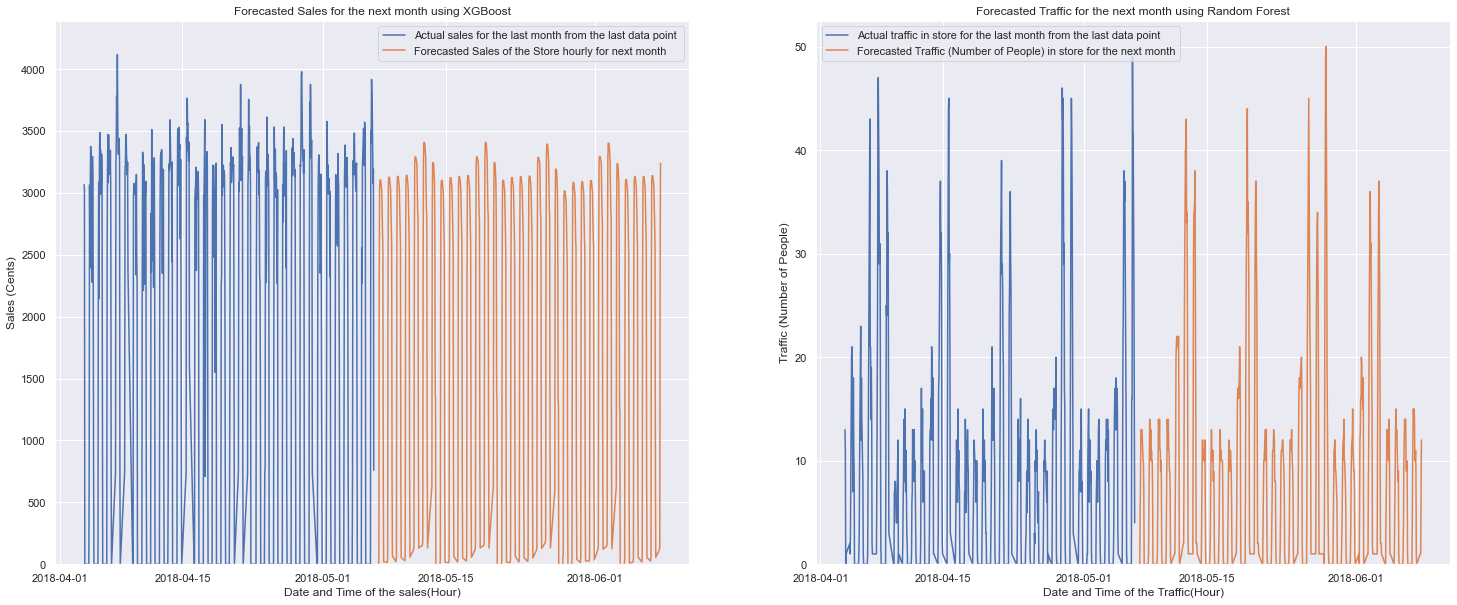

In [116]:
#Plotting the sales and traffic for the next month
plotting_actuals_sales = df_sales_temp[-469:].set_index("Date")#Month sales
plotting_actuals_traffic = df_traffic_temp[-469:].set_index("Date")#Month Traffic

fig, (sales_plot,traffic_plot) = plt.subplots(ncols=2, nrows=1, figsize=(25,10))

#Sales
sales_plot.plot(plotting_actuals_sales["Sales_cents"], label="Actual sales for the last month from the last data point ")
sales_plot.plot(final_sales_forecast_df["Predicted_sales_XGB"], label="Forecasted Sales of the Store hourly for next month")
sales_plot.set_xlabel("Date and Time of the sales(Hour)")
sales_plot.set_ylabel("Sales (Cents)")
sales_plot.set_title("Forecasted Sales for the next month using XGBoost")
sales_plot.set_ylim(bottom=0) #Removing negative predicions if present
sales_plot.legend()


#Traffic 
traffic_plot.plot(plotting_actuals_traffic["No_people"], label="Actual traffic in store for the last month from the last data point")
traffic_plot.plot(final_traffic_forecast_df["Predicted_traffic_RF"], label="Forecasted Traffic (Number of People) in store for the next month")
traffic_plot.set_xlabel("Date and Time of the Traffic(Hour)")
traffic_plot.set_ylabel("Traffic (Number of People)")
traffic_plot.set_title("Forecasted Traffic for the next month using Random Forest")
traffic_plot.set_ylim(bottom=0) #To remove negative predictions if present
traffic_plot.legend()

plt.show()

In [117]:
final_results.head(30)

,Predicted_sales_RF,Predicted_sales_XGB,Predicted_traffic_RF,Predicted_traffic_XGB
Date,,,,
2018-05-07 08:00:00,24.486,0.693005,0,0
2018-05-07 09:00:00,110.653,33.487144,0,0
2018-05-07 10:00:00,2340.131,2300.225830,5,4
2018-05-07 11:00:00,2990.860,3051.654297,8,10
2018-05-07 12:00:00,3242.901,3103.032959,13,13
2018-05-07 13:00:00,3152.948,3103.032959,13,14
2018-05-07 14:00:00,3161.285,3100.365723,13,14
2018-05-07 15:00:00,3048.027,3065.971924,13,14
2018-05-07 16:00:00,2884.549,3043.463379,12,13


In [118]:
final_results.tail(30)

,Predicted_sales_RF,Predicted_sales_XGB,Predicted_traffic_RF,Predicted_traffic_XGB
Date,,,,
2018-06-06 12:00:00,3066.265,3129.987549,12,14
2018-06-06 13:00:00,3141.879,3129.987549,14,15
2018-06-06 14:00:00,3096.889,3127.320312,13,15
2018-06-06 15:00:00,3035.625,3092.926514,14,15
2018-06-06 16:00:00,3026.285,3070.417969,14,14
2018-06-06 17:00:00,3063.040,3028.130127,10,12
2018-06-06 18:00:00,2579.750,2859.487305,9,11
2018-06-06 19:00:00,2659.787,2670.331543,10,10
2018-06-06 20:00:00,2984.607,2571.947021,9,7


# <center>End Of the Project